# NVIDIA Daily Stocks

- Barrera Hernandez Diego alberto

## Librerias


In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as tsa
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error





## Funciones

#### Gráfica de la serie

In [199]:
def plot_time_series(df, y_col, x_col=None, title=None):
    if x_col is None:
        x = df.index
        x_label = "Fecha"
    else:
        x = df[x_col]
        x_label = x_col

    plt.figure(figsize=(12, 6))
    plt.plot(x, df[y_col], label=y_col)

    plt.xlabel(x_label)
    plt.ylabel(y_col)

    if title is None:
        title = f"Comportamiento de {y_col} a lo largo del tiempo"

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


#### Gráfica de componentes

In [200]:
def plot_seasonal_decomposition(series, model='additive', period = 252):

    # Descomposición
    decomp = seasonal_decompose(series, model=model, period=period)

    # Colores fijos
    colors = ['orange', 'green', 'red', 'purple']


    fig = decomp.plot()
    fig.set_size_inches(12, 8)   # Tamaño fijo
    for i, ax in enumerate(fig.axes):
        for line in ax.get_lines():
            line.set_color(colors[i % len(colors)])

    plt.tight_layout()
    plt.show()

    return decomp


#### Gráficas de correlacion

In [201]:
def plot_acf_pacf(series, lags=40):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # ACF
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('Función de Autocorrelación (ACF)')

    # PACF
    plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('Función de Autocorrelación Parcial (PACF)')

    plt.tight_layout()
    plt.show()

#### Test Dickey-Fuller

In [202]:
def adf_test(series):

  """
  Augmented Dickey-Fuller Test (ADF)
  Hipótesis:
  H0: La serie tiene raíz unitaria → No estacionaria
  H1: La serie es estacionaria
  Si p < 0.05 → Rechazamos H0 → La serie es estacionaria
  """
  adf_result = adfuller(series)
  print("\n--- Augmented Dickey-Fuller Test ---")
  print(f"ADF Statistic: {adf_result[0]:.4f}")
  print(f"p-value: {adf_result[1]:.4f}")
  for key, value in adf_result[4].items():
      print(f"Critical Value {key}: {value:.4f}")
  print("Decisión:", "Estacionaria" if adf_result[1] < 0.05 else "No estacionaria")

#### ARMA

In [203]:
def fit_arma(series, p, q):
    """
    Ajusta un modelo ARMA(p,q) usando ARIMA(p,0,q).
    """
    model = tsa.ARIMA(series, order=(p, 0, q))
    result = model.fit()
    print(result.summary())
    return result, model


#### ARIMA

In [204]:
def fit_arima(series, p, d, q):
    """
    Ajusta un modelo ARIMA(p,d,q)
    """
    model = tsa.ARIMA(series, order=(p, d, q))
    result = model.fit()
    print(result.summary())
    return result


#### SARIMA

In [205]:
def fit_sarima(series, order, seasonal_order):
    """
    Ajusta un modelo SARIMA(p,d,q)(P,D,Q,s)
    """
    model = tsa.SARIMAX(series, order=order, seasonal_order=seasonal_order)
    result = model.fit()
    print(result.summary())
    return result


#### Residuos y gráfica

In [206]:
def plot_model_residuals(model_fit, title_suffix=""):

    # Obtener residuos
    residuos = model_fit.resid

    # Graficar residuos
    plt.figure(figsize=(12, 6))
    plt.plot(residuos)
    plt.title(f'Residuos del modelo {title_suffix}')
    plt.xlabel('Fecha')
    plt.ylabel('Residuo')
    plt.grid(True)
    plt.show()

    # Graficar ACF de los residuos
    fig, ax = plt.subplots(figsize=(10, 5))
    lags_to_plot = min(40, len(residuos) - 1)
    plot_acf(residuos, ax=ax, lags=lags_to_plot)
    ax.set_title(f'Función de Autocorrelación (ACF) de los Residuos {title_suffix}')
    plt.show()

### Calculo de errores MAPE con cross val

In [207]:
def _calcular_metricas_prediccion(y_real, y_pred):
    """Calcula MAE, RMSE y MAPE."""

    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))

    # Manejo de división por cero para MAPE
    y_real_no_cero = np.where(y_real == 0, 1e-8, y_real)
    porcentaje_error = np.abs((y_real - y_pred) / y_real_no_cero)
    mape = np.mean(porcentaje_error) * 100

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


def evaluar_modelo_arima_con_cv(clase_modelo, datos_completos, order, n_splits=5, test_size=None):
    """
    Evalúa un modelo ARIMA/ARMA de statsmodels usando CV (Rolling Origin).

    Utiliza índices enteros para la predicción (posiciones) para evitar errores
    con la indexación de fechas de statsmodels.
    """

    X_dummy = np.arange(len(datos_completos)).reshape(-1, 1)
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    mae_scores, rmse_scores, mape_scores = [], [], []

    print(f"Iniciando CV con {n_splits} folds...")

    for i, (train_index, test_index) in enumerate(tscv.split(X_dummy)):

        y_train = datos_completos.iloc[train_index]
        y_test = datos_completos.iloc[test_index]

        print(f"  > Fold {i+1}: Entrenando con {len(y_train)} puntos, prediciendo {len(y_test)} puntos...")

        modelo_fold = clase_modelo(endog=y_train, order=order)


        resultado_fit = modelo_fold.fit()

        start_pos = len(y_train)
        end_pos = len(y_train) + len(y_test) - 1

        y_pred = resultado_fit.predict(start=start_pos, end=end_pos)

        if isinstance(y_pred, pd.Series):
            y_pred.index = y_test.index

        metricas_fold = _calcular_metricas_prediccion(y_test, y_pred)

        mae_scores.append(metricas_fold['MAE'])
        rmse_scores.append(metricas_fold['RMSE'])
        mape_scores.append(metricas_fold['MAPE'])

    resultados = {
        'MAE_Promedio': np.mean(mae_scores),
        'RMSE_Promedio': np.mean(rmse_scores),
        'MAPE_Promedio': np.mean(mape_scores),
        'Num_Folds': n_splits
    }

    return resultados

### Pronostico

In [208]:
def realizar_pronostico_arima_arma(clase_modelo, datos_historicos, order, n_steps=10):

    modelo_final = clase_modelo(endog=datos_historicos, order=order)
    resultado_fit = modelo_final.fit()

    print("--- Modelo ajustado al conjunto de datos completo ---")

    plot_historico = None
    plot_forecast = None
    xlabel_text = ""
    usar_fechas = False
    forecast_results_obj = None

    try:
        freq = datos_historicos.index.freq or pd.infer_freq(datos_historicos.index)

        if freq is None:
            raise ValueError("Frecuencia no detectada")

        print(f"Frecuencia detectada ({freq}). Usando fechas para el pronóstico.")
        forecast_results_obj = resultado_fit.get_forecast(steps=n_steps)
        forecast_values = forecast_results_obj.predicted_mean


        last_date = datos_historicos.index[-1]
        indice_futuro = pd.date_range(start=last_date, periods=n_steps + 1, freq=freq)[1:]

        plot_historico = datos_historicos
        plot_forecast = pd.Series(forecast_values.values, index=indice_futuro)
        xlabel_text = "Fecha"
        usar_fechas = True

    except (ValueError, AttributeError) as e:
        print(f"Advertencia: No se pudo usar fechas futuras ({e}). Se graficará usando 'Pasos'.")

        start_pos = len(datos_historicos)
        end_pos = len(datos_historicos) + n_steps - 1
        forecast_values = resultado_fit.predict(start=start_pos, end=end_pos)

        indice_futuro_int = np.arange(start_pos, end_pos + 1)


        plot_historico = datos_historicos.reset_index(drop=True)
        plot_forecast = pd.Series(forecast_values.values, index=indice_futuro_int)
        xlabel_text = "Pasos (Steps desde el inicio)"
        usar_fechas = False


    df_forecast = pd.DataFrame({
        'Pronostico': plot_forecast.values
    }, index=plot_forecast.index)
    if usar_fechas: df_forecast.index.name = 'Fecha Futura'
    else: df_forecast.index.name = 'Paso Futuro'


    plt.figure(figsize=(12, 6))
    plot_historico.plot(label='Datos Históricos', color='blue')
    plot_forecast.plot(label=f'Pronóstico ({n_steps} pasos)', color='red', linestyle='--', linewidth=2)

    if usar_fechas and forecast_results_obj is not None:
        conf_int = forecast_results_obj.conf_int()
        if len(conf_int) == len(plot_forecast.index):
             conf_int.index = plot_forecast.index
             plt.fill_between(conf_int.index,
                              conf_int.iloc[:, 0],
                              conf_int.iloc[:, 1],
                              color='red', alpha=0.1, label='IC 95%')

    plt.title(f'Pronóstico ARMA/ARIMA {order} vs. Datos Históricos')
    plt.xlabel(xlabel_text)
    plt.ylabel('Valor de la Serie')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n--- Resultados del Pronóstico (Primeros 5 valores) ---")
    return df_forecast

### Análisis de residuos

In [209]:
def analizar_residuos_modelo(clase_modelo, datos, order):
    """
    Ajusta el modelo y realiza un diagnóstico completo de los residuos.
    """

    modelo = clase_modelo(endog=datos, order=order)
    resultado = modelo.fit()

    print("--- Generando Gráficas de Diagnóstico ---")
    plt.rc('figure', figsize=(12, 8))
    resultado.plot_diagnostics()
    plt.tight_layout()
    plt.show()

    lb_test = acorr_ljungbox(resultado.resid, lags=[10], return_df=True)

    p_value_ljung = lb_test['lb_pvalue'].values[0]

    print("\n--- Resultados de Pruebas Estadísticas ---")
    print(f"1. Prueba Ljung-Box (Autocorrelación a 10 lags):")
    print(f"   P-valor: {p_value_ljung:.4f}")

    if p_value_ljung > 0.05:
        print("CONCLUSIÓN: Los residuos son independientes (Ruido Blanco). El modelo captura bien la correlación.")
    else:
        print("CONCLUSIÓN: Hay correlación en los residuos. Considera aumentar p o q.")

    print("\n--- Resumen del Modelo (Busca Jarque-Bera abajo) ---")
    print(resultado.summary().tables[2])


### Pronosticos y valores

In [210]:
def pronostico_arma_mes_ultimos_5(
    serie_original,
    serie_diff,
    order=(1, 0, 1),
    pasos=5,
    texto=""
):
    """
    Pronóstico ARMA sobre 1 mes/año bursátil.
    Compara los últimos 5 valores reales vs predichos (NO futuro).
    Reconstruye precios en nivel.
    """

    fechas = []
    precios_reales = []
    precios_predichos = []

    for t in range(len(serie_diff) - pasos, len(serie_diff)):
        # Datos hasta t-1
        y_train = serie_diff.iloc[:t]

        # Último precio observado
        last_price = serie_original.iloc[t]

        # Ajustar ARMA
        modelo = ARIMA(endog=y_train, order=order)
        resultado = modelo.fit()

        # Pronóstico 1 paso (en diferencias)
        diff_pred = resultado.forecast(steps=1).iloc[0]

        # Reconstrucción a nivel
        precio_pred = last_price + diff_pred

        fechas.append(serie_original.index[t])
        precios_reales.append(serie_original.iloc[t])
        precios_predichos.append(precio_pred)

    resultados = pd.DataFrame({
        'Precio_Real': precios_reales,
        'Precio_Predicho': precios_predichos
    }, index=fechas)

    # -------- Gráfica --------
    plt.figure(figsize=(8, 4))
    plt.plot(resultados.index, resultados['Precio_Real'],
             marker='o', label='Real')
    plt.plot(resultados.index, resultados['Precio_Predicho'],
             marker='o', linestyle='--', label='Predicho')
    plt.title(f'ARMA(1,0,1) – Últimos 5 valores ({texto})')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Ajustado')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return resultados

In [211]:
def pronostico_arima_mes_ultimos_5(
    serie_original,
    order=(1, 1, 1),
    pasos=5,
    texto = ""
):
    """
    Pronóstico ARIMA sobre 1 mes/año bursátil.
    Compara los últimos 5 valores reales vs predichos (NO futuro).
    """

    fechas = []
    precios_reales = []
    precios_predichos = []

    for t in range(len(serie_original) - pasos, len(serie_original)):
        # Datos hasta t-1
        y_train = serie_original.iloc[:t]

        # Valor real
        y_real = serie_original.iloc[t]

        # Ajustar ARIMA
        modelo = ARIMA(endog=y_train, order=order)
        resultado = modelo.fit()

        # Pronóstico 1 paso adelante
        y_pred = resultado.forecast(steps=1).iloc[0]

        fechas.append(serie_original.index[t])
        precios_reales.append(y_real)
        precios_predichos.append(y_pred)

    resultados = pd.DataFrame({
        'Precio_Real': precios_reales,
        'Precio_Predicho': precios_predichos
    }, index=fechas)

    # -------- Gráfica --------
    plt.figure(figsize=(8, 4))
    plt.plot(resultados.index, resultados['Precio_Real'],
             marker='o', label='Real')
    plt.plot(resultados.index, resultados['Precio_Predicho'],
             marker='o', linestyle='--', label='Predicho')
    plt.title(f'ARIMA(1,1,1) – Últimos 5 valores ({texto})')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Ajustado')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return resultados


# Contexto
Características principales del dataset

- Periodo cubierto: Desde el 3 de enero del 2000 hasta el 2 de septiembre de 2025.

- Datos incluidos :

- Open: Precio de apertura ajustado por splits.

- High: Precio máximo intradía.

- Low: Precio mínimo intradía.

- Close: Precio de cierre ajustado.

- Adj Close: Cierre ajustado (en NVDA suele coincidir con el Close).

- Volume: Volumen de acciones negociadas.

- Número de registros: 6,455 días de trading, sin valores faltantes.

- Formato: Tabular, con columnas estándar de mercado.

- Licencia: Apache 2.0 (uso libre con atribución).

## Serie Original

### Extraccion y procesmiento de datos

In [212]:
nvidia_series = pd.read_csv("/content/nvidia.csv")

In [213]:
nvidia_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6455 entries, 0 to 6454
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6455 non-null   int64  
 1   Unnamed: 1  6455 non-null   object 
 2   NVDA        6455 non-null   float64
 3   NVDA.1      6455 non-null   float64
 4   NVDA.2      6455 non-null   float64
 5   NVDA.3      6455 non-null   float64
 6   NVDA.4      6455 non-null   float64
 7   NVDA.5      6455 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 403.6+ KB


In [214]:
nvidia_series

,Unnamed: 0,Unnamed: 1,NVDA,NVDA.1,NVDA.2,NVDA.3,NVDA.4,NVDA.5
0,0,2000-01-03,0.098438,0.099219,0.091927,0.097526,0.089425,300912000
1,1,2000-01-04,0.095833,0.096094,0.090104,0.094922,0.087038,300480000
2,2,2000-01-05,0.092188,0.093750,0.090495,0.091797,0.084172,188352000
3,3,2000-01-06,0.091797,0.091797,0.082292,0.085807,0.078680,120480000
4,4,2000-01-07,0.085417,0.088151,0.084115,0.087240,0.079994,71184000
...,...,...,...,...,...,...,...,...
6450,6450,2025-08-26,180.059998,182.389999,178.809998,181.770004,181.770004,168688200
6451,6451,2025-08-27,181.979996,182.490005,179.100006,181.600006,181.600006,235518900
6452,6452,2025-08-28,180.820007,184.470001,176.410004,180.169998,180.169998,281787800
6453,6453,2025-08-29,178.110001,178.149994,173.149994,174.179993,174.179993,243257900


Conversion de la variable Unnamed: 1 como indice del conjunto de datos

In [215]:
nvidia_series['Unnamed: 1'] = pd.to_datetime(nvidia_series['Unnamed: 1'])
nvidia_series.set_index('Unnamed: 1', inplace=True)

In [216]:
nvidia_series = nvidia_series.rename(columns={'NVDA.4': 'Adj Close'})


### Seleccion de variable

### Visualizacion la serie de tiempo


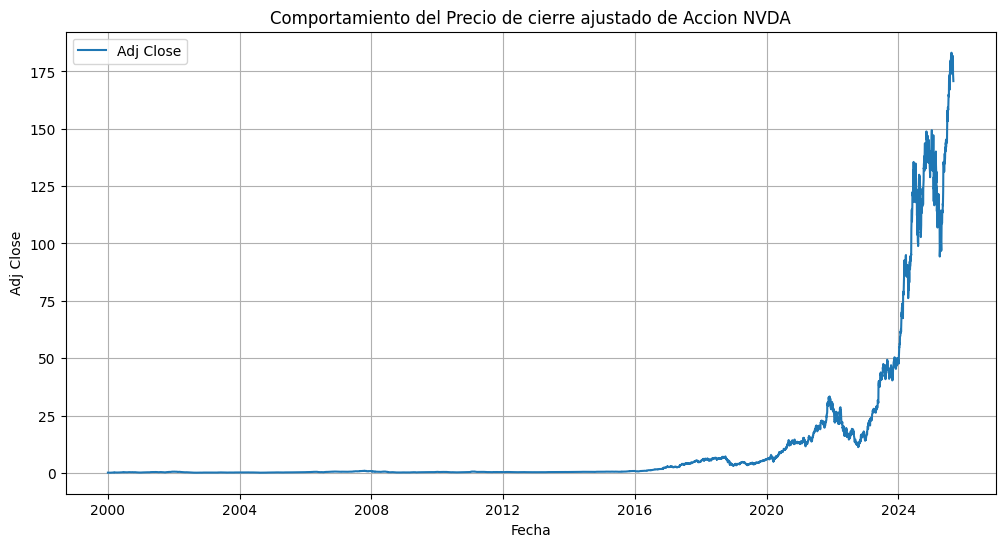

In [217]:
plot_time_series(nvidia_series, y_col='Adj Close', title='Comportamiento del Precio de cierre ajustado de Accion NVDA')

In [218]:
obs_por_anio = nvidia_series.resample('Y').size()
obs_por_anio.head()


,0
Unnamed: 1,
2000-12-31,252
2001-12-31,248
2002-12-31,252
2003-12-31,252
2004-12-31,252


### Análisis de componentes





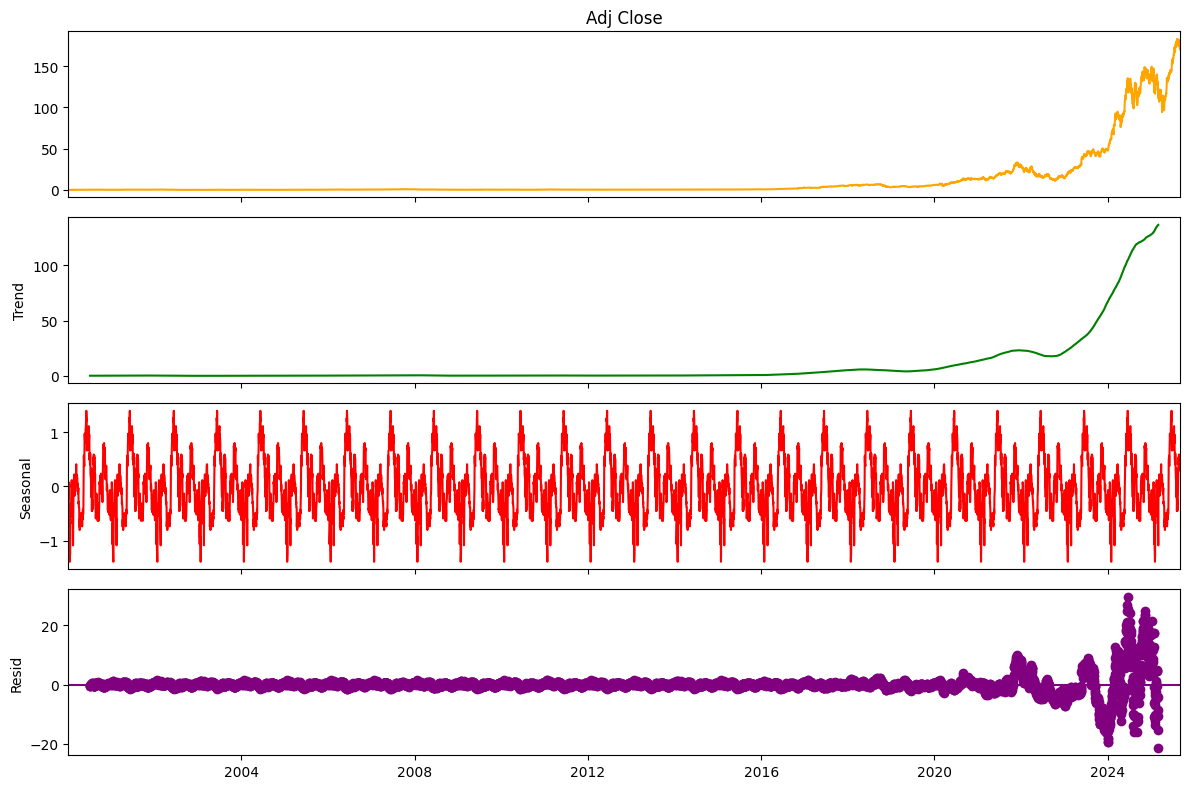

In [219]:
    plot_seasonal_decomposition(nvidia_series['Adj Close'], model='additive', period=252)


### Análisis de autocorrelación y estacionariedad

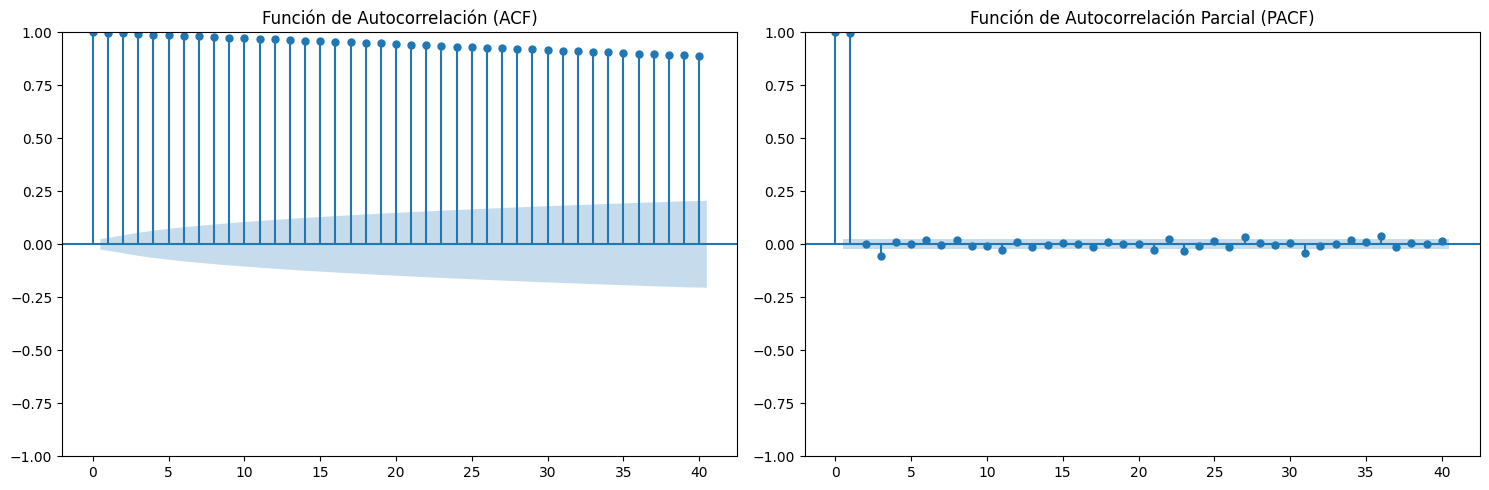

In [220]:
plot_acf_pacf(nvidia_series['Adj Close'], lags=40)

In [221]:
adf_test(nvidia_series['Adj Close'])


--- Augmented Dickey-Fuller Test ---
ADF Statistic: 3.3859
p-value: 1.0000
Critical Value 1%: -3.4314
Critical Value 5%: -2.8620
Critical Value 10%: -2.5670
Decisión: No estacionaria




## Segmento de serie seleccionado para modelado después de análisis

### Para un año

Para el análisis de corto plazo se selecciona el último año bursátil disponible, definido como las últimas 252 observaciones de la serie, lo cual corresponde aproximadamente a un año de negociación en el mercado financiero.

In [222]:
#inicio = '2024-09-02'
#final = '2025-09-02'
#nvidia_series_anual = nvidia_series.loc[inicio:final]

nvidia_series_anual = nvidia_series.tail(252)



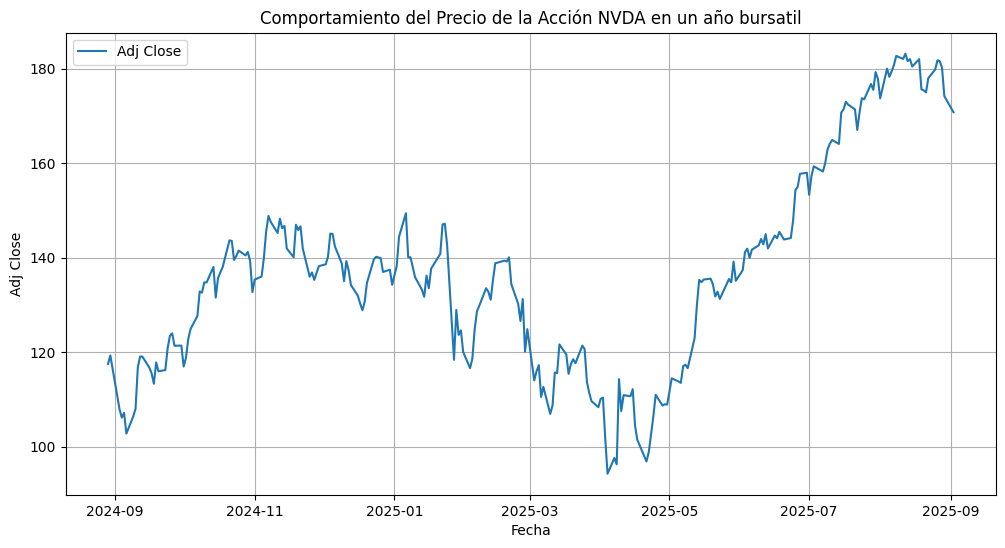

In [223]:
plot_time_series(nvidia_series_anual, y_col='Adj Close', title='Comportamiento del Precio de la Acción NVDA en un año bursatil')

#### Análisis de componentes

Dado que el análisis se restringe a un único año bursátil, no es posible identificar estacionalidad anual. Por lo tanto, se utiliza un período de 5 observaciones, correspondiente a la estacionalidad semanal bursátil, lo cual permite analizar patrones de corto plazo dentro del año.

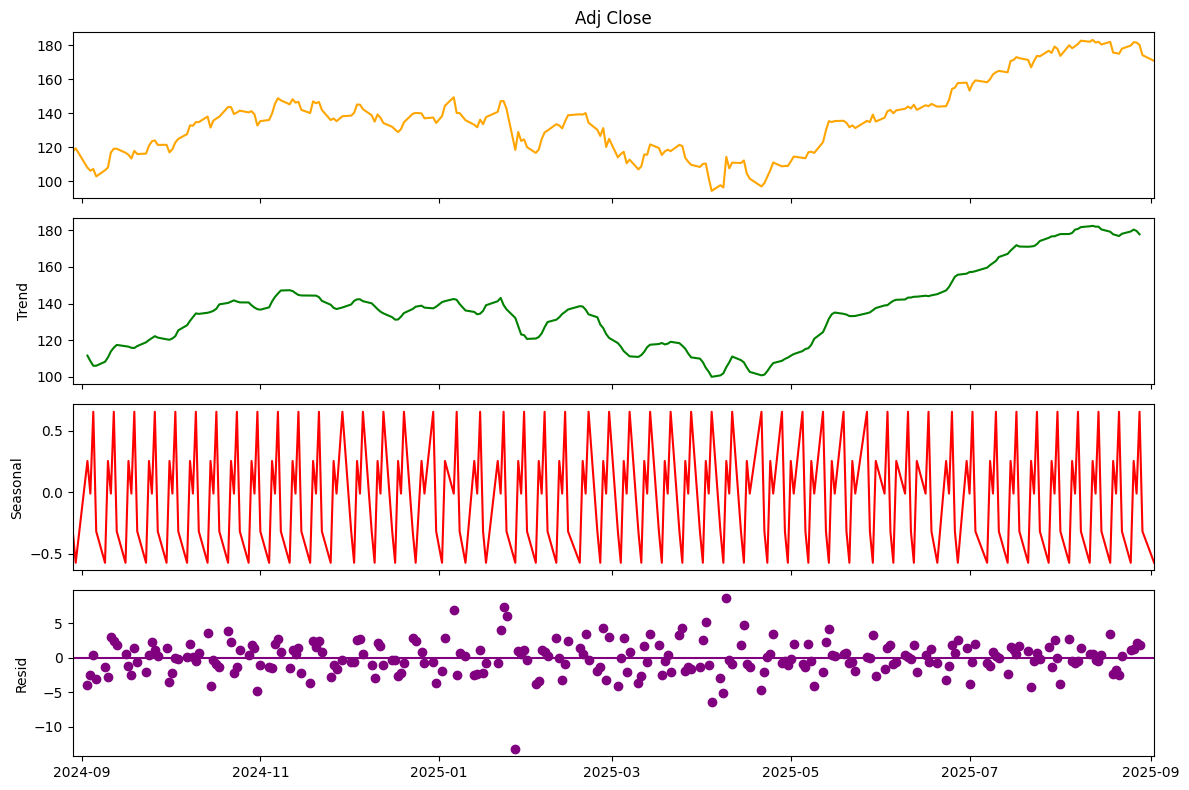

In [224]:
plot_seasonal_decomposition(nvidia_series_anual['Adj Close'], model='additive', period=5)

#### Análisis de autocorrelación y estacionariedad

Las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) se calculan considerando 30 rezagos. Dado que la serie es diaria y de frecuencia bursátil, este rango permite analizar la dependencia del valor actual con observaciones de hasta 30 días hábiles en el pasado. En particular, se cubren relaciones de muy corto plazo (1 a 5 días), posibles efectos semanales (≈5 días bursátiles), quincenales (≈10 días) y mensuales (≈21 días bursátiles), sin sobrecargar la visualización.

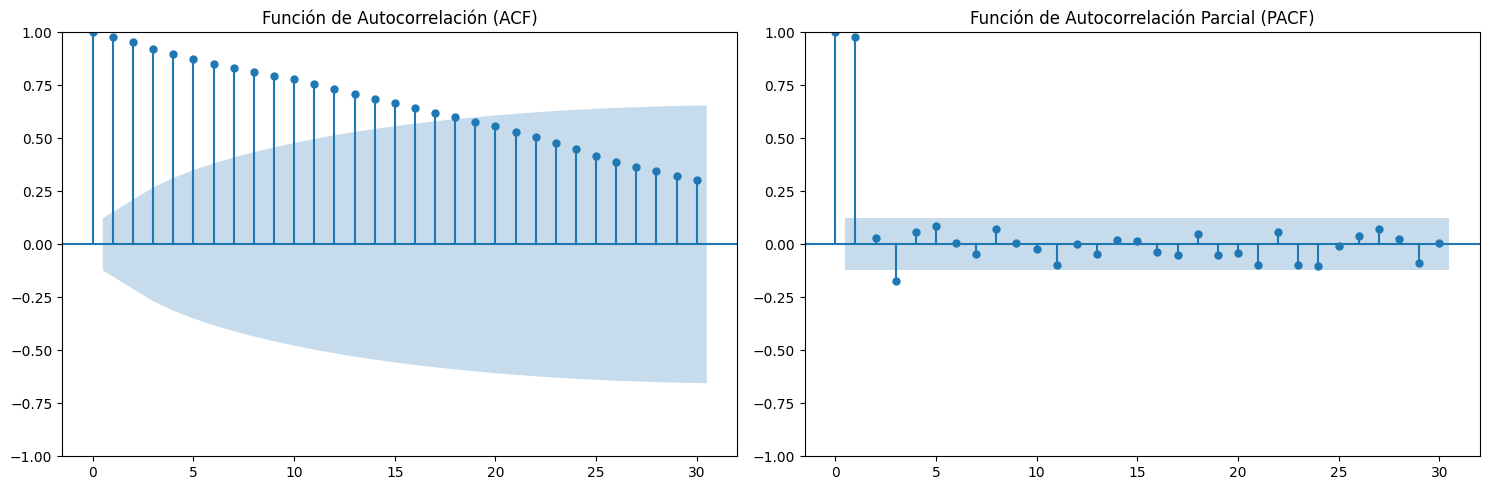

In [225]:
plot_acf_pacf(nvidia_series_anual['Adj Close'], lags=30)

In [226]:
adf_test(nvidia_series_anual['Adj Close'])


--- Augmented Dickey-Fuller Test ---
ADF Statistic: -0.9567
p-value: 0.7687
Critical Value 1%: -3.4571
Critical Value 5%: -2.8733
Critical Value 10%: -2.5730
Decisión: No estacionaria


### Para un mes

In [227]:
#inicio = '2024-12-01'
#final = '2024-12-31'
#nvidia_series_mes = nvidia_series.loc[inicio:final]

nvidia_series_mes = nvidia_series.tail(252)

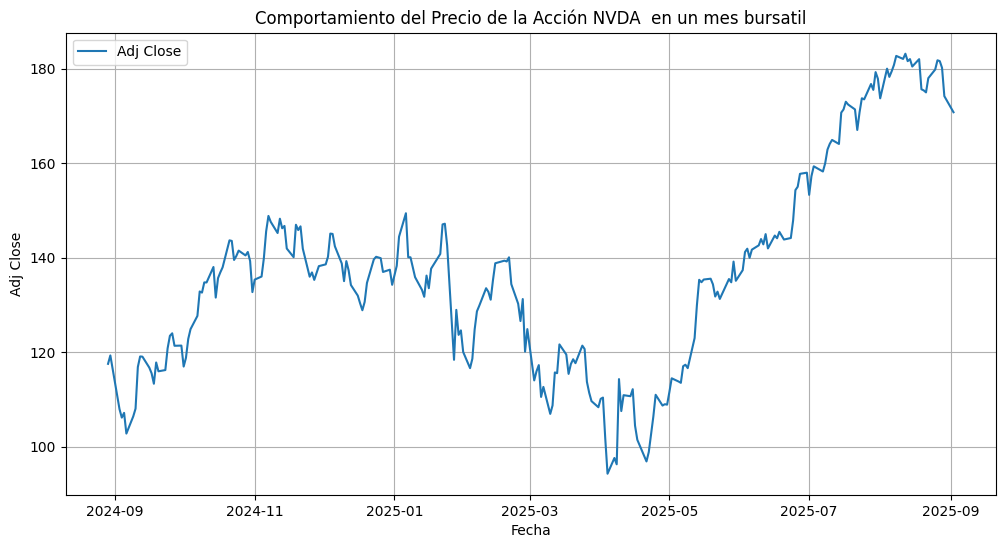

In [228]:
plot_time_series(nvidia_series_mes, y_col='Adj Close', title='Comportamiento del Precio de la Acción NVDA  en un mes bursatil')

#### Análisis de componentes

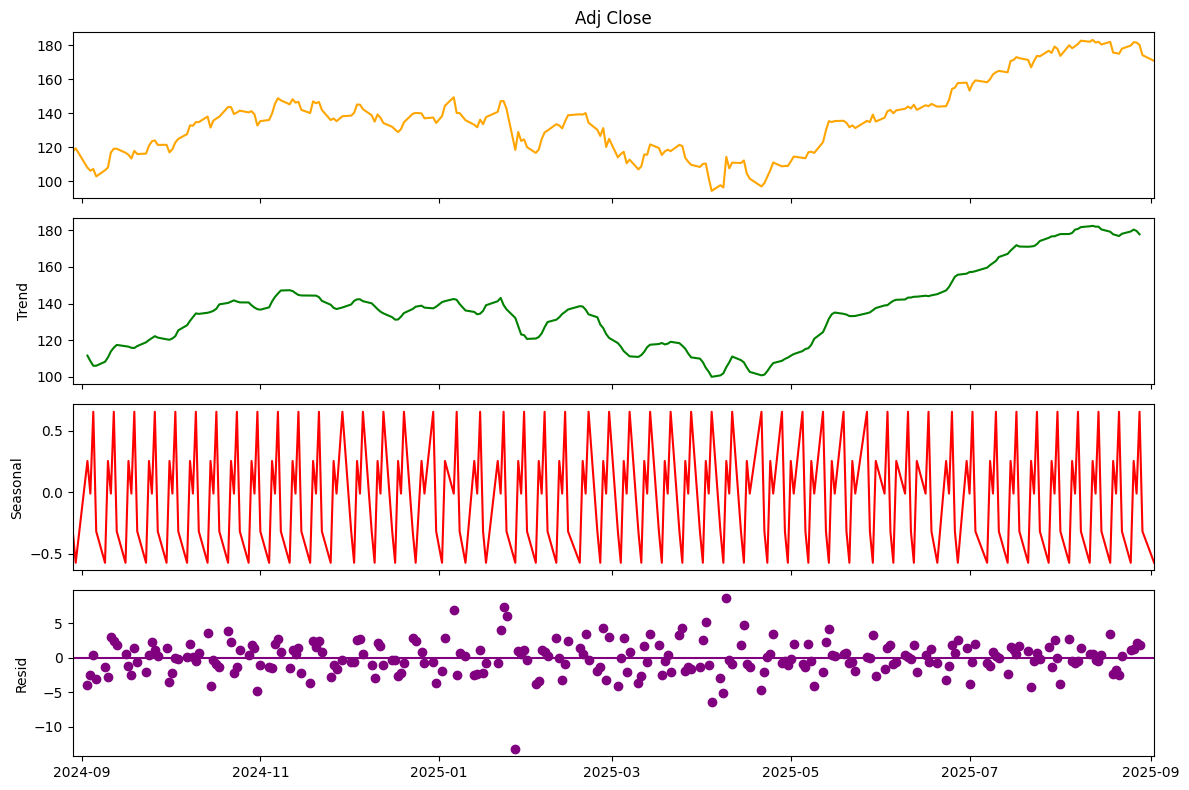

In [229]:
plot_seasonal_decomposition(nvidia_series_mes['Adj Close'], model='additive', period=5)

#### Análisis de autocorrelación y estacionariedad

Para el análisis mensual se utilizan 5 rezagos, correspondientes aproximadamente a una semana bursátil, lo cual permite explorar dependencias de muy corto plazo sin sobreajustar el análisis.

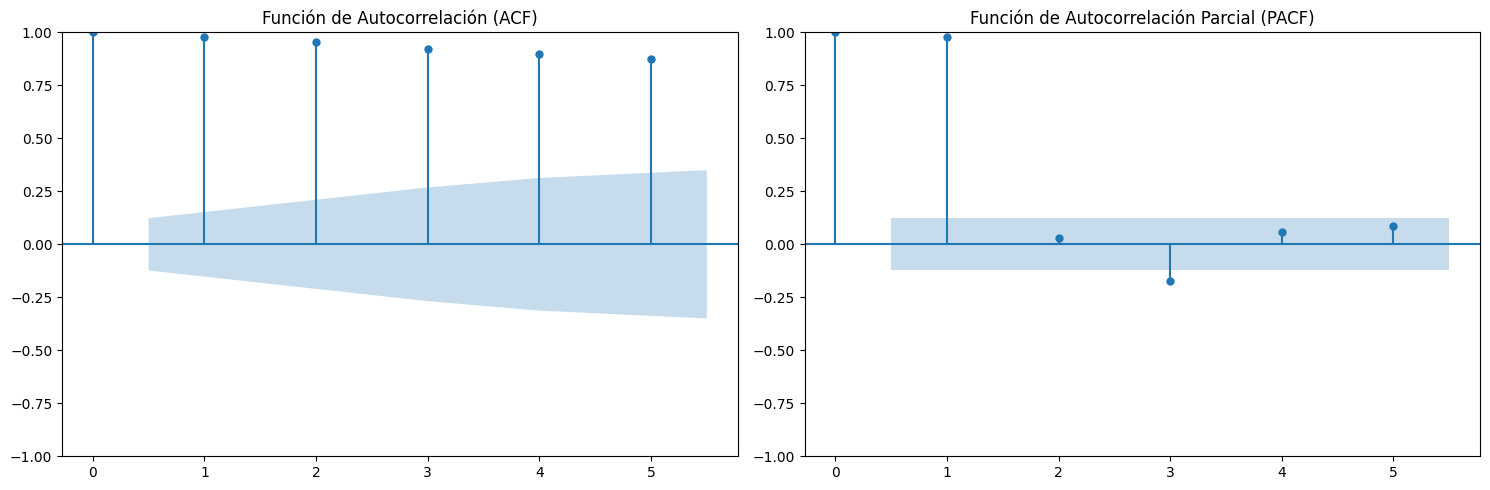

In [230]:
plot_acf_pacf(nvidia_series_mes['Adj Close'], lags=5)

In [231]:
adf_test(nvidia_series_mes['Adj Close'])


--- Augmented Dickey-Fuller Test ---
ADF Statistic: -0.9567
p-value: 0.7687
Critical Value 1%: -3.4571
Critical Value 5%: -2.8733
Critical Value 10%: -2.5730
Decisión: No estacionaria


## Transformaciones: Diferenciación

### Para un año

In [232]:
nvidia_series_anual_diff1 = nvidia_series_anual.diff().dropna()

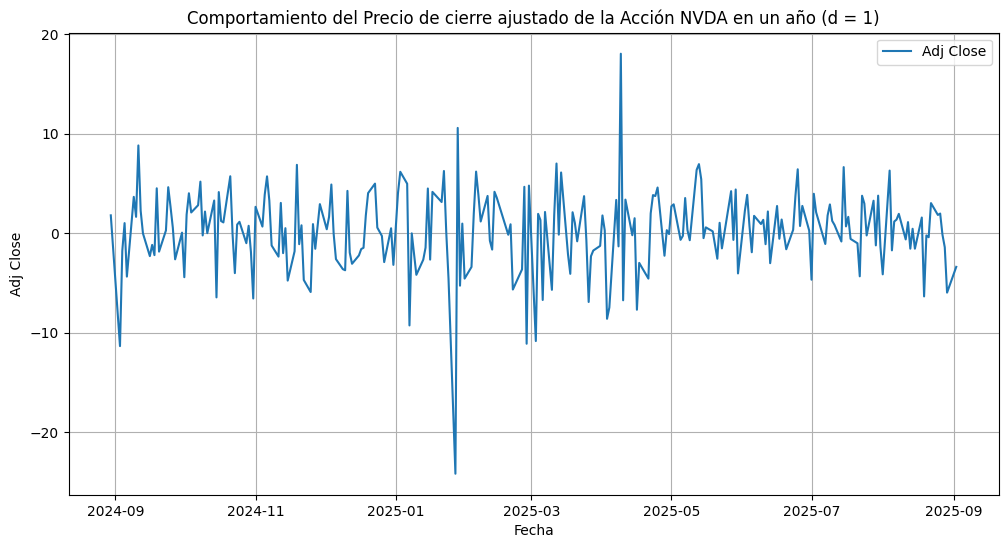

In [233]:
plot_time_series(nvidia_series_anual_diff1, y_col='Adj Close', title='Comportamiento del Precio de cierre ajustado de la Acción NVDA en un año (d = 1)' )

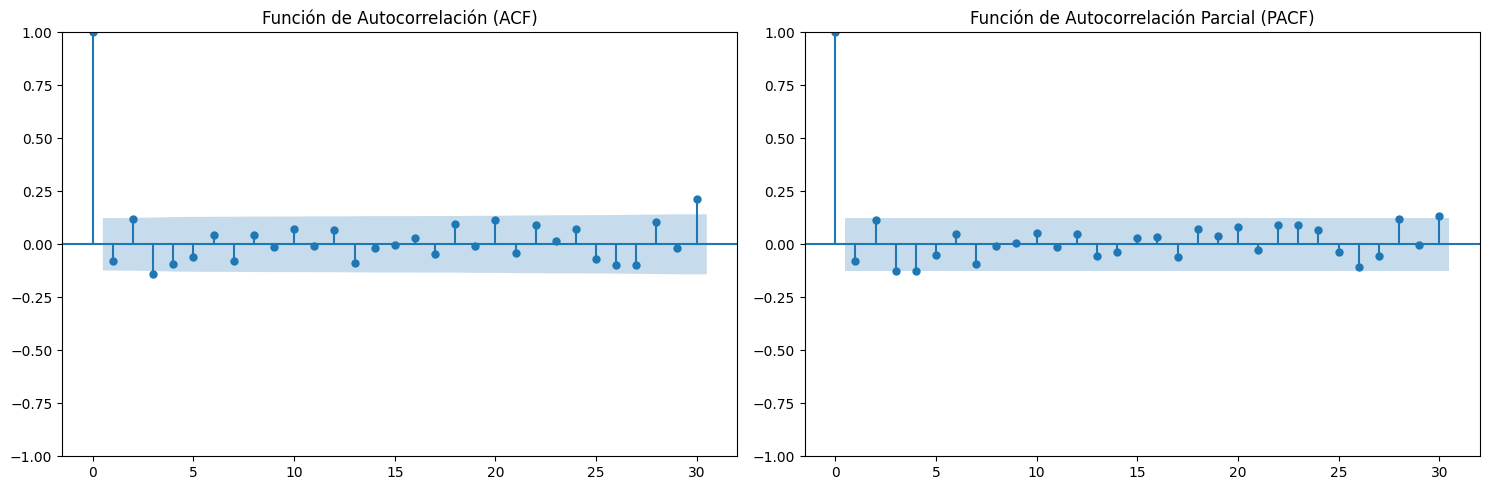

In [234]:
plot_acf_pacf(nvidia_series_anual_diff1['Adj Close'], lags=30)

In [235]:
adf_test(nvidia_series_anual_diff1['Adj Close'])


--- Augmented Dickey-Fuller Test ---
ADF Statistic: -9.3219
p-value: 0.0000
Critical Value 1%: -3.4571
Critical Value 5%: -2.8733
Critical Value 10%: -2.5730
Decisión: Estacionaria


## Para un mes

In [236]:
nvidia_series_mes_diff1 = nvidia_series_mes.diff().dropna()

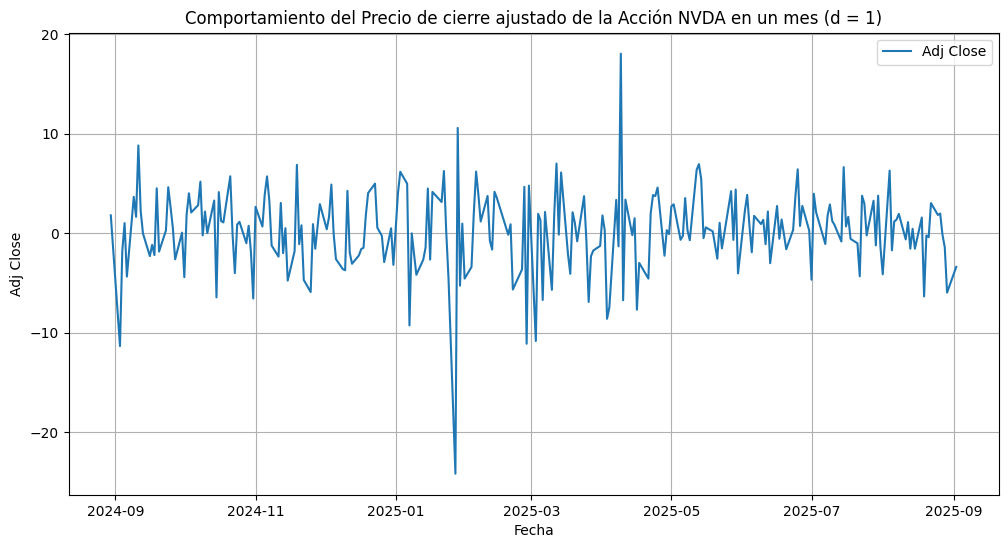

In [237]:
plot_time_series(nvidia_series_mes_diff1, y_col='Adj Close', title='Comportamiento del Precio de cierre ajustado de la Acción NVDA en un mes (d = 1)' )

In [238]:
adf_test(nvidia_series_mes_diff1['NVDA'])


--- Augmented Dickey-Fuller Test ---
ADF Statistic: -9.4726
p-value: 0.0000
Critical Value 1%: -3.4571
Critical Value 5%: -2.8733
Critical Value 10%: -2.5730
Decisión: Estacionaria


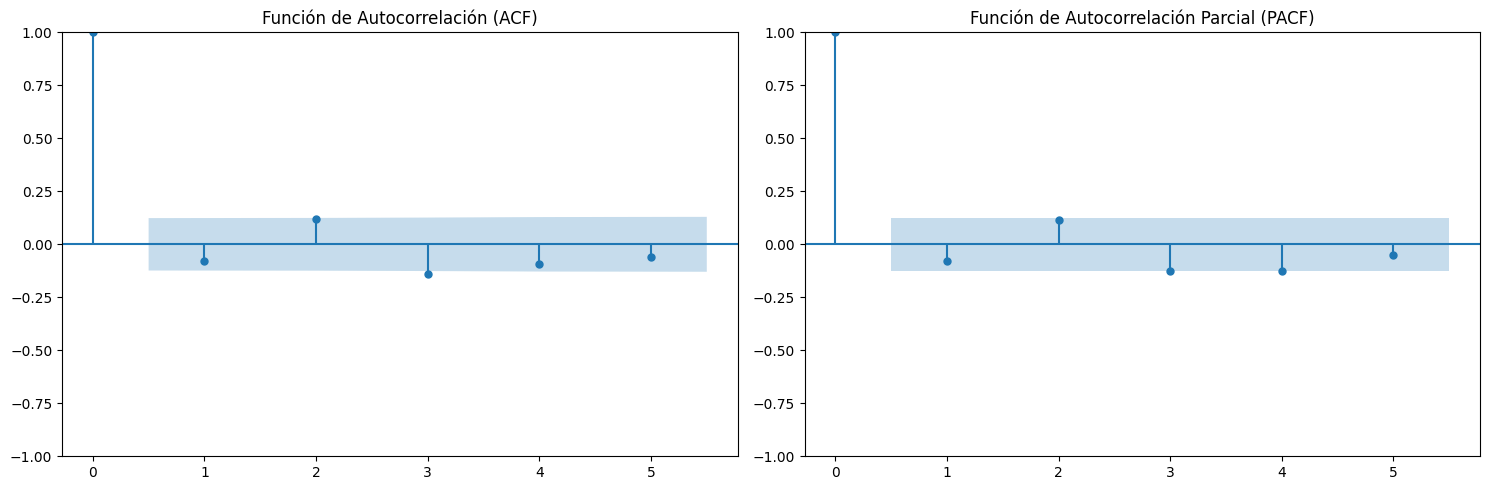

In [239]:
plot_acf_pacf(nvidia_series_mes_diff1['Adj Close'], lags=5)

# Modelos propuestos

## Para un año

#### Primer intento de modelos

##### ARMA

In [240]:
from statsmodels.tsa.arima.model import ARIMA

arma_101 = ARIMA(
    nvidia_series_anual_diff1['Adj Close'],
    order=(1, 0, 1)
).fit()

print(arma_101.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -703.785
Date:                Thu, 18 Dec 2025   AIC                           1415.570
Time:                        14:49:37   BIC                           1429.672
Sample:                             0   HQIC                          1421.245
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2110      0.264      0.800      0.424      -0.306       0.728
ar.L1         -0.9794      0.030    -32.899      0.000      -1.038      -0.921
ma.L1          0.9455      0.049     19.402      0.0

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -703.785
Date:                Thu, 18 Dec 2025   AIC                           1415.570
Time:                        14:49:38   BIC                           1429.672
Sample:                             0   HQIC                          1421.245
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2110      0.264      0.800      0.424      -0.306       0.728
ar.L1         -0.9794      0.030    -32.899      0.000      -1.038      -0.921
ma.L1          0.9455      0.049     19.402      0.0

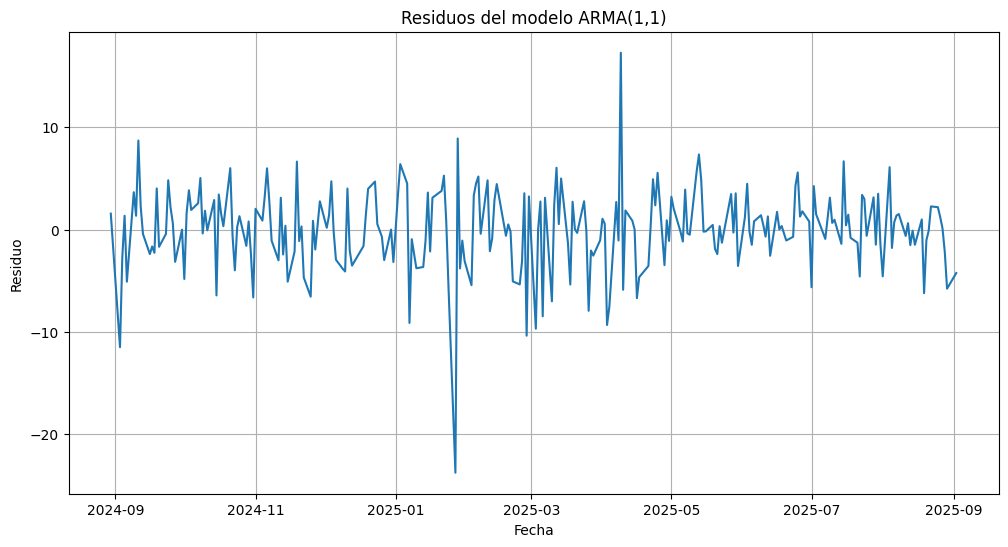

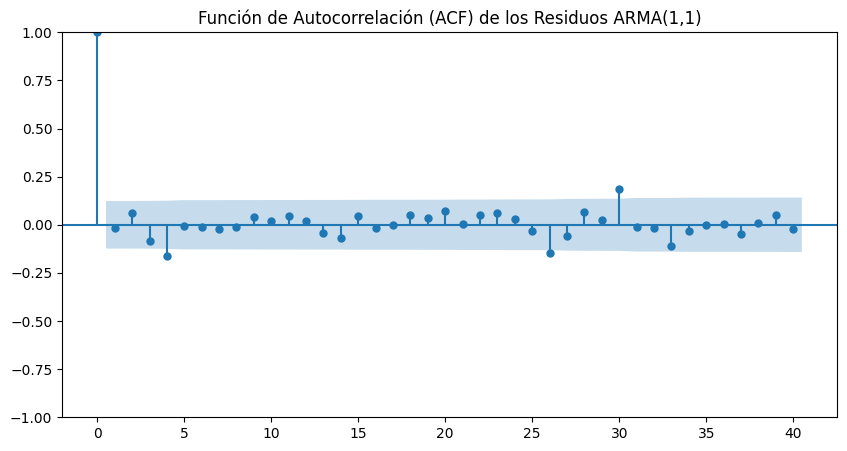

In [241]:
# Modelo
arma_anual_normal_1, arma_year = fit_arma(nvidia_series_anual_diff1['Adj Close'], p=1, q=1)

# Graficar residuos y ACF
plot_model_residuals(arma_anual_normal_1, title_suffix="ARMA(1,1)")


##### ARIMA

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -704.147
Date:                Thu, 18 Dec 2025   AIC                           1414.295
Time:                        14:49:39   BIC                           1424.871
Sample:                             0   HQIC                          1418.551
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9794      0.029    -33.600      0.000      -1.037      -0.922
ma.L1          0.9457      0.047     19.927      0.000       0.853       1.039
sigma2        15.9893      0.811     19.718      0.0

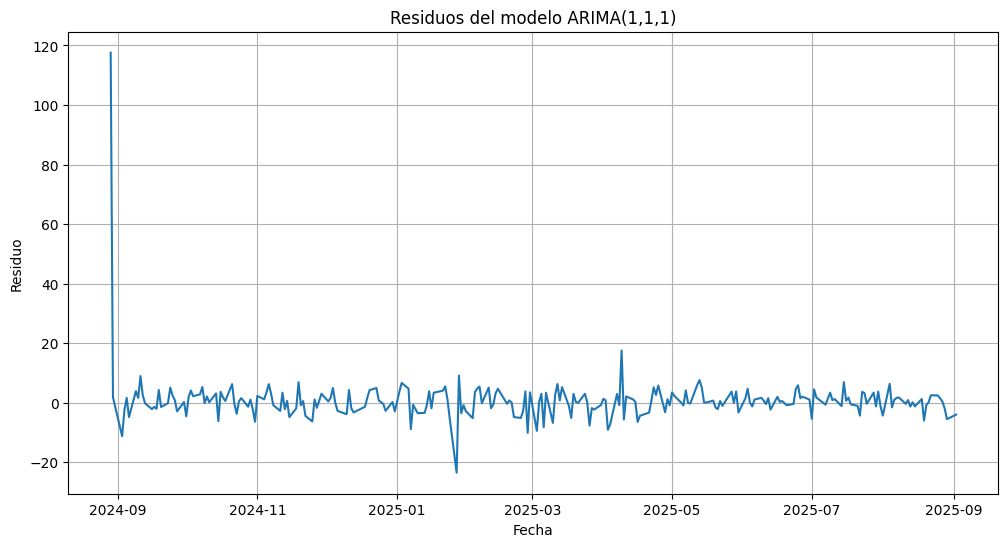

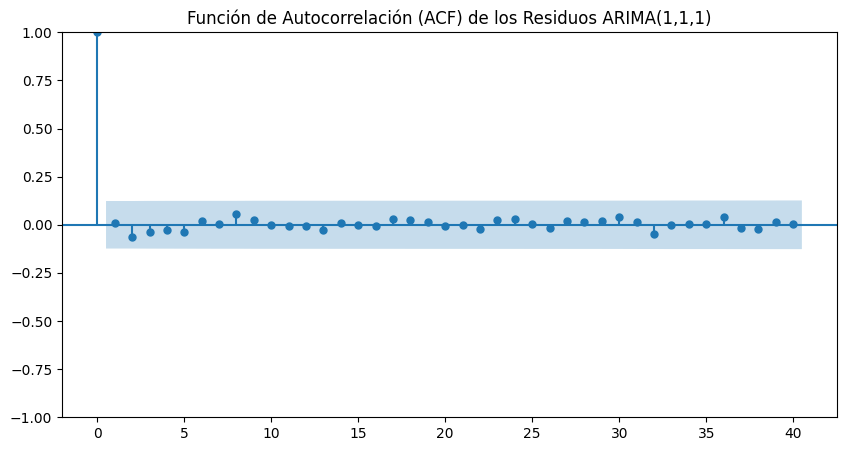

In [242]:
arma_anual_dif_1 = fit_arima(nvidia_series_anual['Adj Close'], p=1, q=1, d=1)

# Graficar residuos y ACF
plot_model_residuals(arma_anual_dif_1, title_suffix="ARIMA(1,1,1)")

In [243]:
arima_111 = ARIMA(
    nvidia_series_anual['Adj Close'],
    order=(1, 1, 1)
).fit()

print(arima_111.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -704.147
Date:                Thu, 18 Dec 2025   AIC                           1414.295
Time:                        14:49:40   BIC                           1424.871
Sample:                             0   HQIC                          1418.551
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9794      0.029    -33.600      0.000      -1.037      -0.922
ma.L1          0.9457      0.047     19.927      0.000       0.853       1.039
sigma2        15.9893      0.811     19.718      0.0

In [244]:
arima_101 = ARIMA(
    nvidia_series_anual['Adj Close'],
    order=(1, 1, 0)
).fit()

arima_011 = ARIMA(
    nvidia_series_anual['Adj Close'],
    order=(0, 1, 1)
).fit()


In [245]:
print("ARIMA(1,1,0) AIC:", arima_101.aic)
print("ARIMA(0,1,1) AIC:", arima_011.aic)
print("ARIMA(1,1,1) AIC:", arima_111.aic)


ARIMA(1,1,0) AIC: 1418.5715942429988
ARIMA(0,1,1) AIC: 1418.8254290004502
ARIMA(1,1,1) AIC: 1414.2946993038859


##### SARIMA

Un modelo SARIMA $(p, d, q)(P, D, Q)_S$ está diseñado para series con Estacionalidad (S), es decir, patrones que se repiten en intervalos fijos (ej., cada 12 meses, cada 4 trimestres).La serie de precios de NVDA no cumple con este requisito clave debido a lo siguiente:

- Dominio de la Tendencia: La gráfica está dominada por una fuerte tendencia alcista y por fluctuaciones irregulares, no por un ciclo que se repita en fechas fijas.
- Falta de Patrones Recurrentes: No se observa un pico o valle que aparezca sistemáticamente cada $S$ períodos.
- Los movimientos son ruido aleatorio o eventos únicos (cambio de sentimiento en el mercado, noticias), no patrones de calendario.


 Aplicar el componente estacional $(P, D, Q)_S$ a esta serie es innecesario, ya que solo agregaría parámetros inútiles que no mejorarán la capacidad predictiva del modelo.

### Análisis de residuos

ARMA

--- Generando Gráficas de Diagnóstico ---


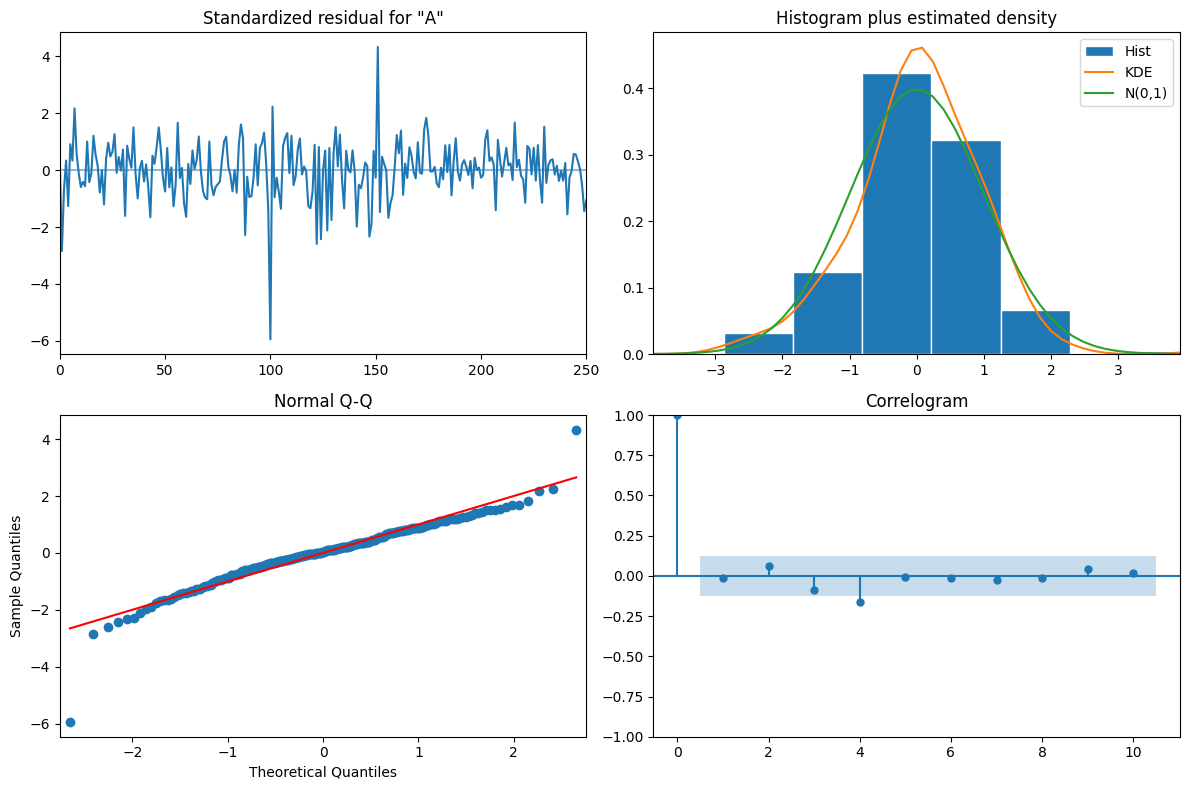


--- Resultados de Pruebas Estadísticas ---
1. Prueba Ljung-Box (Autocorrelación a 10 lags):
   P-valor: 0.4089
CONCLUSIÓN: Los residuos son independientes (Ruido Blanco). El modelo captura bien la correlación.

--- Resumen del Modelo (Busca Jarque-Bera abajo) ---
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               336.64
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.78
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.45


In [246]:
analizar_residuos_modelo(ARIMA, nvidia_series_anual_diff1['Adj Close'] , order=(1, 0, 1))

ARIMA

--- Generando Gráficas de Diagnóstico ---


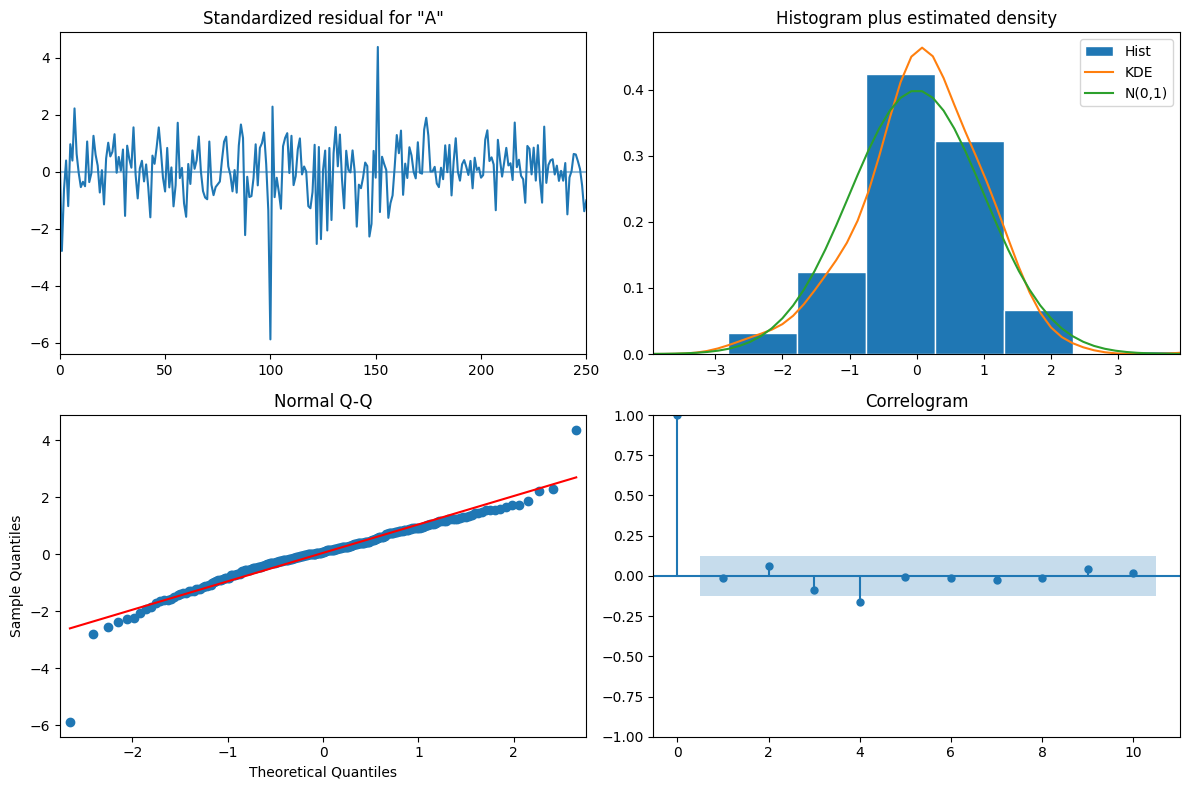


--- Resultados de Pruebas Estadísticas ---
1. Prueba Ljung-Box (Autocorrelación a 10 lags):
   P-valor: 0.9825
CONCLUSIÓN: Los residuos son independientes (Ruido Blanco). El modelo captura bien la correlación.

--- Resumen del Modelo (Busca Jarque-Bera abajo) ---
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               336.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.78
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.45


In [247]:
analizar_residuos_modelo(ARIMA, nvidia_series_anual['Adj Close'] , order=(1, 1, 1))

### Métricas de evaluación con Validación Cruzada

In [248]:
metricas_arma_año = evaluar_modelo_arima_con_cv(
    clase_modelo=ARIMA,
    datos_completos=nvidia_series_anual_diff1['Adj Close'],
    order=(1, 0, 1),
    n_splits=5,
    test_size=15
)

Iniciando CV con 5 folds...
  > Fold 1: Entrenando con 176 puntos, prediciendo 15 puntos...
  > Fold 2: Entrenando con 191 puntos, prediciendo 15 puntos...
  > Fold 3: Entrenando con 206 puntos, prediciendo 15 puntos...
  > Fold 4: Entrenando con 221 puntos, prediciendo 15 puntos...
  > Fold 5: Entrenando con 236 puntos, prediciendo 15 puntos...


In [249]:
metricas_arima_año = evaluar_modelo_arima_con_cv(
    clase_modelo=ARIMA,
    datos_completos=nvidia_series_anual['Adj Close'],
    order=(1, 1, 1),
    n_splits=5,
    test_size=15
)

Iniciando CV con 5 folds...
  > Fold 1: Entrenando con 177 puntos, prediciendo 15 puntos...
  > Fold 2: Entrenando con 192 puntos, prediciendo 15 puntos...
  > Fold 3: Entrenando con 207 puntos, prediciendo 15 puntos...
  > Fold 4: Entrenando con 222 puntos, prediciendo 15 puntos...
  > Fold 5: Entrenando con 237 puntos, prediciendo 15 puntos...


### Resultados

In [250]:
print("\n--- Resultados Promedio de Validación Cruzada (5 Folds) ---")
print(f"Modelo: ARMA(1, 0, 1)")
print(f"MAE Promedio:  {metricas_arma_año['MAE_Promedio']:.4f}")
print(f"RMSE Promedio: {metricas_arma_año['RMSE_Promedio']:.4f}")
print(f"MAPE Promedio: {metricas_arma_año['MAPE_Promedio']:.4f}%")
print("----------------------------------------------------------")


--- Resultados Promedio de Validación Cruzada (5 Folds) ---
Modelo: ARMA(1, 0, 1)
MAE Promedio:  2.0013
RMSE Promedio: 2.6354
MAPE Promedio: 101.9760%
----------------------------------------------------------


In [251]:
print("\n--- Resultados Promedio de Validación Cruzada (5 Folds) ---")
print(f"Modelo: ARIMA(1, 1, 1)")
print(f"MAE Promedio:  {metricas_arima_año['MAE_Promedio']:.4f}")
print(f"RMSE Promedio: {metricas_arima_año['RMSE_Promedio']:.4f}")
print(f"MAPE Promedio: {metricas_arima_año['MAPE_Promedio']:.4f}%")
print("----------------------------------------------------------")


--- Resultados Promedio de Validación Cruzada (5 Folds) ---
Modelo: ARIMA(1, 1, 1)
MAE Promedio:  5.0477
RMSE Promedio: 6.3861
MAPE Promedio: 3.0897%
----------------------------------------------------------


### Pronostico

ARMA(1,1)

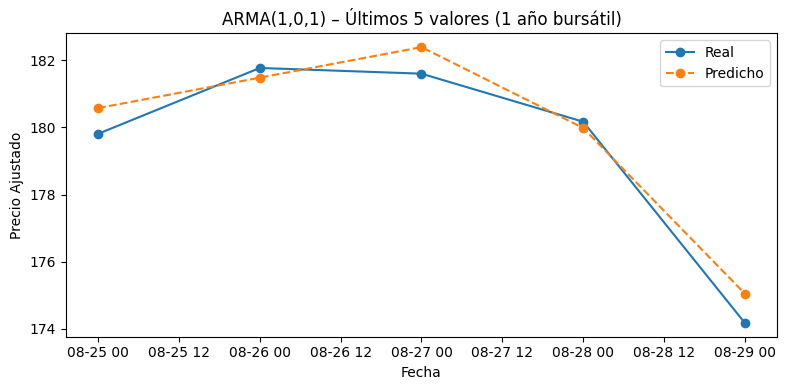

Últimos 5 valores reales vs predichos (ARMA – 1 año bursátil):
            Precio_Real  Precio_Predicho
2025-08-25   179.809998       180.576081
2025-08-26   181.770004       181.481285
2025-08-27   181.600006       182.390665
2025-08-28   180.169998       179.983831
2025-08-29   174.179993       175.052234


In [252]:
tabla_arma_anual = pronostico_arma_mes_ultimos_5(
    serie_original=nvidia_series_anual['Adj Close'],
    serie_diff=nvidia_series_anual_diff1['Adj Close'],
    order=(1, 0, 1),
    pasos=5,
    texto="1 año bursátil"
)

print("Últimos 5 valores reales vs predichos (ARMA – 1 año bursátil):")
print(tabla_arma_anual)


--- Modelo ajustado al conjunto de datos completo ---
Advertencia: No se pudo usar fechas futuras (Frecuencia no detectada). Se graficará usando 'Pasos'.


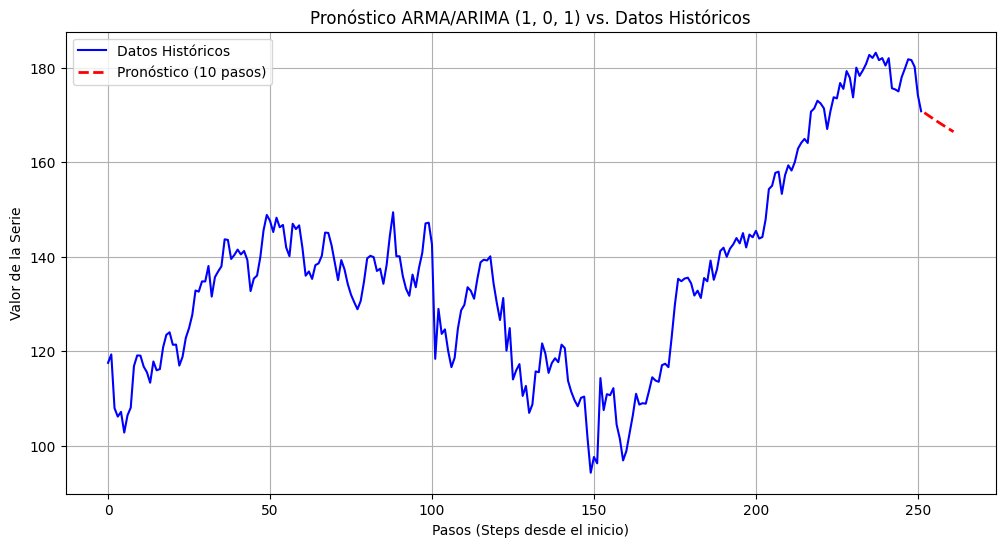


--- Resultados del Pronóstico (Primeros 5 valores) ---


,Pronostico
Paso Futuro,
252,170.473461
253,170.000397
254,169.533921
255,169.073940
256,168.620365
257,168.173105
258,167.732074
259,167.297184
260,166.868351


In [253]:
realizar_pronostico_arima_arma(ARIMA, nvidia_series_anual['Adj Close'], order=(1, 0, 1), n_steps=10)

ARIMA(1,1,1)

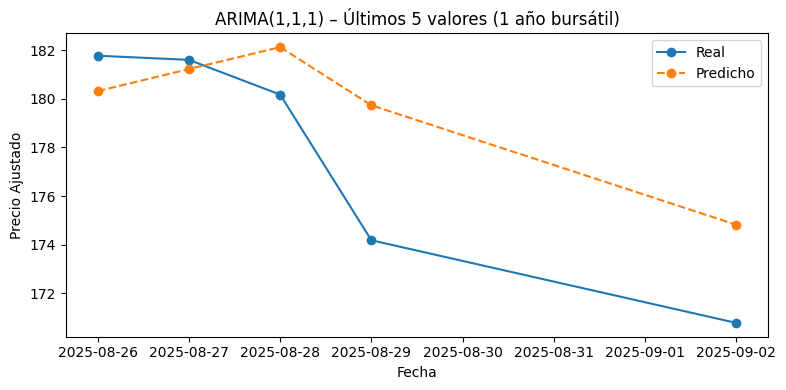

Últimos 5 valores reales vs predichos (ARIMA – 1 año bursátil):
            Precio_Real  Precio_Predicho
2025-08-26   181.770004       180.313842
2025-08-27   181.600006       181.220527
2025-08-28   180.169998       182.123331
2025-08-29   174.179993       179.730720
2025-09-02   170.779999       174.817181


In [254]:
tabla_arima_anual = pronostico_arima_mes_ultimos_5(
    serie_original=nvidia_series_anual['Adj Close'],
    order=(1, 1, 1),
    pasos=5,
    texto="1 año bursátil"
)

print("Últimos 5 valores reales vs predichos (ARIMA – 1 año bursátil):")
print(tabla_arima_anual)

--- Modelo ajustado al conjunto de datos completo ---
Advertencia: No se pudo usar fechas futuras (Frecuencia no detectada). Se graficará usando 'Pasos'.


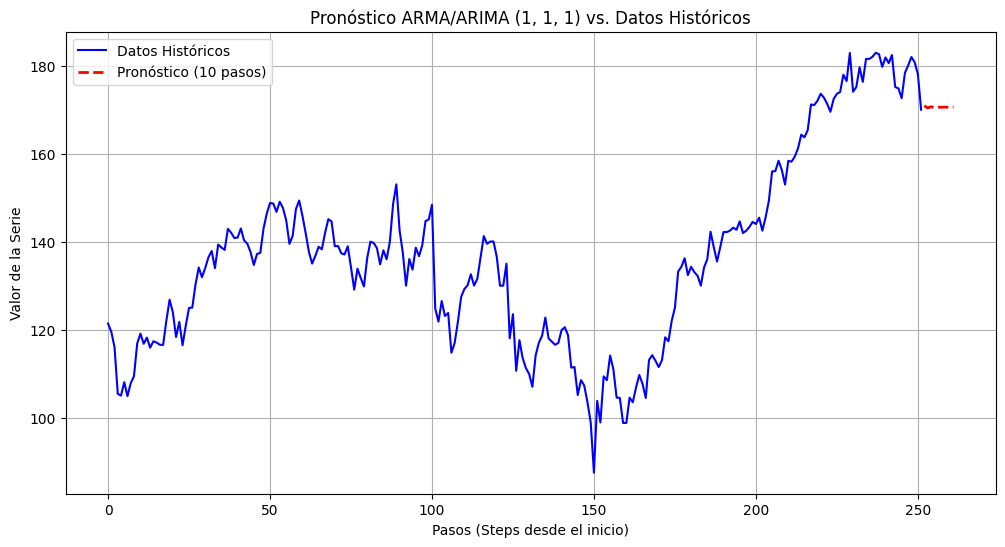


--- Resultados del Pronóstico (Primeros 5 valores) ---


,Pronostico
Paso Futuro,
252,170.900763
253,170.392507
254,170.679291
255,170.517473
256,170.608779
257,170.557259
258,170.586329
259,170.569926
260,170.579182


In [255]:
realizar_pronostico_arima_arma(ARIMA, nvidia_series_anual['NVDA'], order=(1, 1, 1), n_steps=10)

## Para un mes

### Intento de modelos

ARMA

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -703.785
Date:                Thu, 18 Dec 2025   AIC                           1415.570
Time:                        14:49:47   BIC                           1429.672
Sample:                             0   HQIC                          1421.245
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2110      0.264      0.800      0.424      -0.306       0.728
ar.L1         -0.9794      0.030    -32.899      0.000      -1.038      -0.921
ma.L1          0.9455      0.049     19.402      0.0

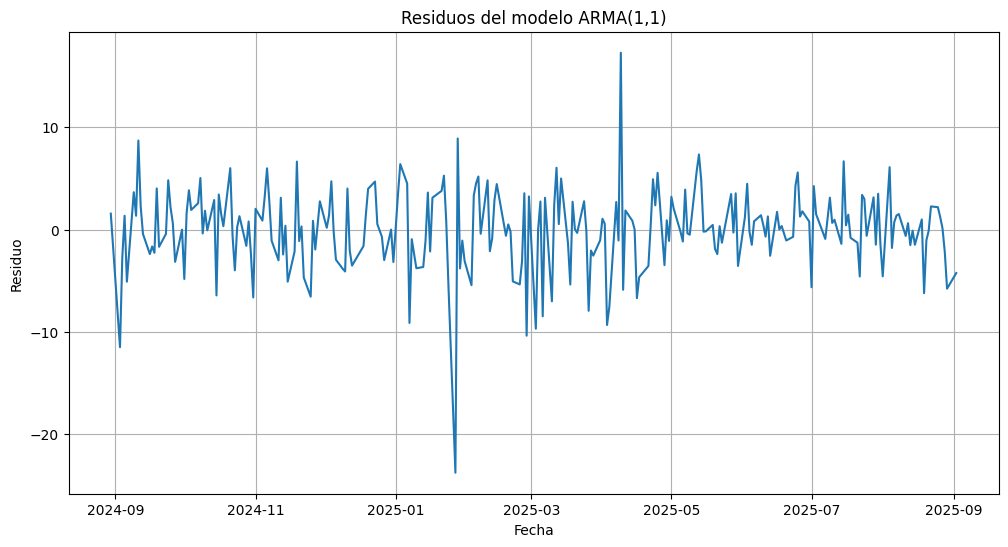

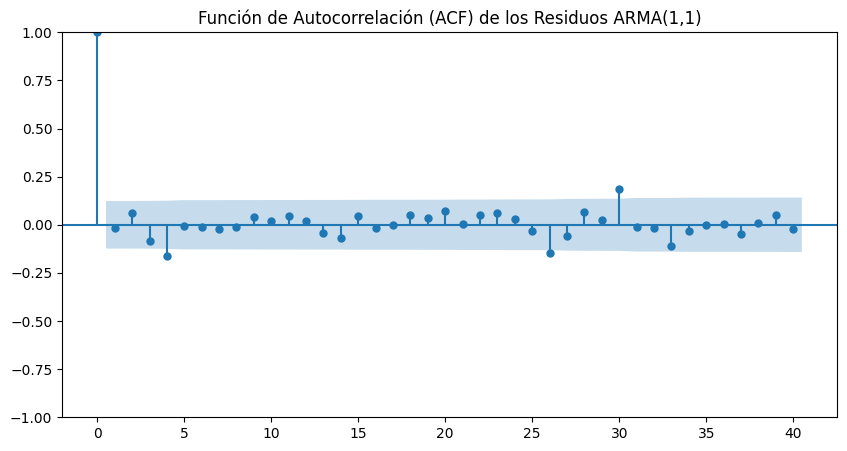

In [256]:
# Modelo
arma_mensual_1, arma_month = fit_arma(nvidia_series_mes_diff1['Adj Close'], p=1, q=1)

# Graficar residuos y ACF
plot_model_residuals(arma_mensual_1, title_suffix="ARMA(1,1)")


ARIMA

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -704.147
Date:                Thu, 18 Dec 2025   AIC                           1414.295
Time:                        14:49:48   BIC                           1424.871
Sample:                             0   HQIC                          1418.551
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9794      0.029    -33.600      0.000      -1.037      -0.922
ma.L1          0.9457      0.047     19.927      0.000       0.853       1.039
sigma2        15.9893      0.811     19.718      0.0

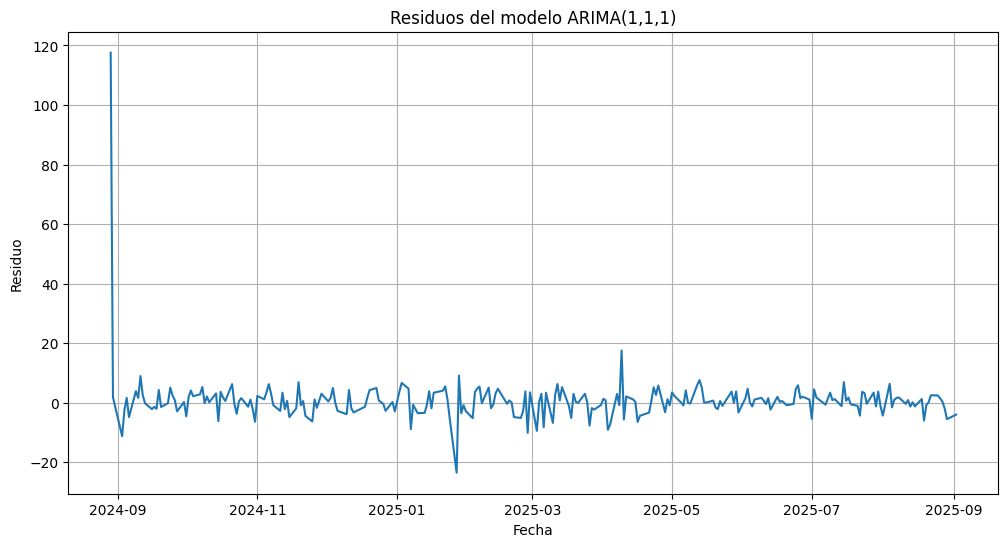

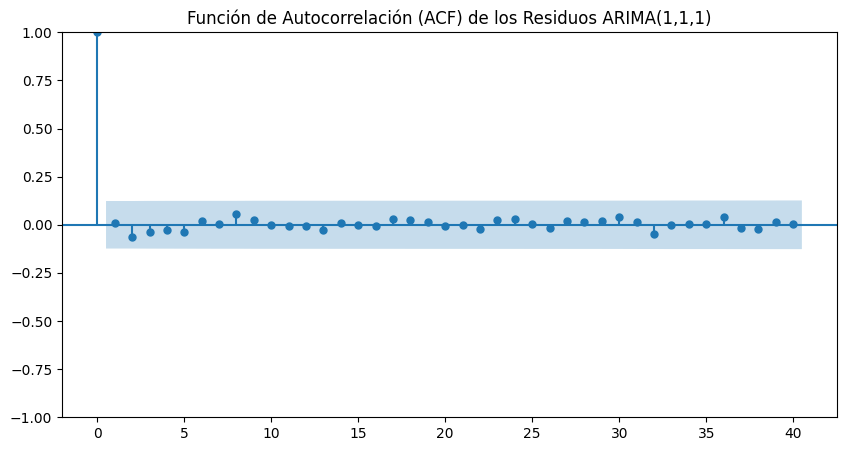

In [257]:
# Modelo
arima_mensual_1 = fit_arima(nvidia_series_mes['Adj Close'], p=1, q=1, d=1)

# Graficar residuos y ACF
plot_model_residuals(arima_mensual_1, title_suffix="ARIMA(1,1,1)")

SARIMA

Un modelo SARIMA  (p,d,q)(P,D,Q)S  está diseñado para series con Estacionalidad (S), es decir, patrones que se repiten en intervalos fijos (ej., cada 12 meses, cada 4 trimestres).La serie de precios de NVDA no cumple con este requisito clave debido a lo siguiente:

Dominio de la Tendencia: La gráfica está dominada por una fuerte tendencia alcista y por fluctuaciones irregulares, no por un ciclo que se repita en fechas fijas.
Falta de Patrones Recurrentes: No se observa un pico o valle que aparezca sistemáticamente cada  S  períodos.
Los movimientos son ruido aleatorio o eventos únicos (cambio de sentimiento en el mercado, noticias), no patrones de calendario.
Aplicar el componente estacional  (P,D,Q)S  a esta serie es innecesario, ya que solo agregaría parámetros inútiles que no mejorarán la capacidad predictiva del modelo.

### Análisis de residuos

ARMA

--- Generando Gráficas de Diagnóstico ---


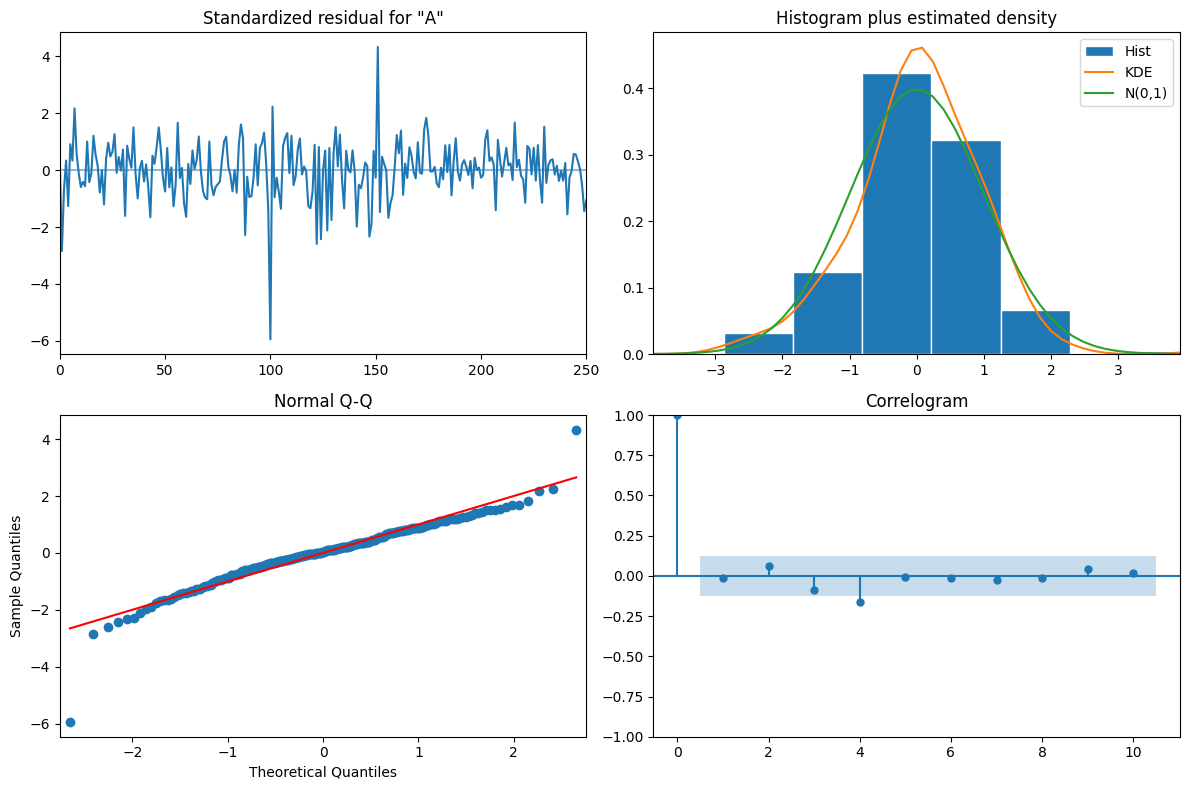


--- Resultados de Pruebas Estadísticas ---
1. Prueba Ljung-Box (Autocorrelación a 10 lags):
   P-valor: 0.4089
CONCLUSIÓN: Los residuos son independientes (Ruido Blanco). El modelo captura bien la correlación.

--- Resumen del Modelo (Busca Jarque-Bera abajo) ---
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               336.64
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.78
Prob(H) (two-sided):                  0.05   Kurtosis:                         8.45


In [258]:
analizar_residuos_modelo(ARIMA, nvidia_series_mes_diff1['Adj Close'] , order=(1, 0, 1))

ARIMA

--- Generando Gráficas de Diagnóstico ---


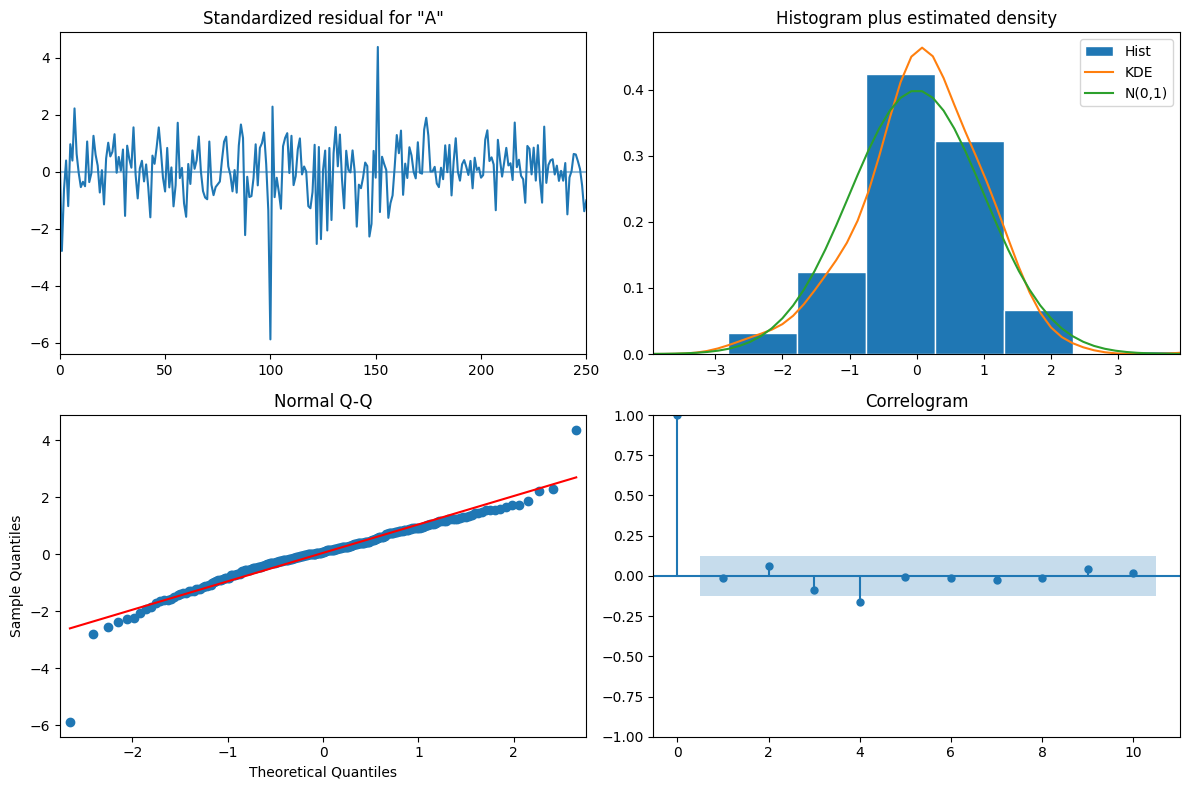


--- Resultados de Pruebas Estadísticas ---
1. Prueba Ljung-Box (Autocorrelación a 10 lags):
   P-valor: 0.9825
CONCLUSIÓN: Los residuos son independientes (Ruido Blanco). El modelo captura bien la correlación.

--- Resumen del Modelo (Busca Jarque-Bera abajo) ---
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               336.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.78
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.45


In [259]:
analizar_residuos_modelo(ARIMA, nvidia_series_mes['Adj Close'] , order=(1, 1, 1))

### Métricas de evaluación con Validación Cruzada

In [260]:
metricas_arma_mes = evaluar_modelo_arima_con_cv(
    clase_modelo=ARIMA,
    datos_completos=nvidia_series_mes_diff1['Adj Close'],
    order=(1, 0, 1),
    n_splits=5,
    test_size=3
)

Iniciando CV con 5 folds...
  > Fold 1: Entrenando con 236 puntos, prediciendo 3 puntos...
  > Fold 2: Entrenando con 239 puntos, prediciendo 3 puntos...
  > Fold 3: Entrenando con 242 puntos, prediciendo 3 puntos...
  > Fold 4: Entrenando con 245 puntos, prediciendo 3 puntos...
  > Fold 5: Entrenando con 248 puntos, prediciendo 3 puntos...


In [261]:
metricas_arima_mes = evaluar_modelo_arima_con_cv(
    clase_modelo=ARIMA,
    datos_completos=nvidia_series_mes['Adj Close'],
    order=(1, 1, 1),
    n_splits=5,
    test_size=3
)

Iniciando CV con 5 folds...
  > Fold 1: Entrenando con 237 puntos, prediciendo 3 puntos...
  > Fold 2: Entrenando con 240 puntos, prediciendo 3 puntos...
  > Fold 3: Entrenando con 243 puntos, prediciendo 3 puntos...
  > Fold 4: Entrenando con 246 puntos, prediciendo 3 puntos...
  > Fold 5: Entrenando con 249 puntos, prediciendo 3 puntos...


### Resultados

In [262]:
print("\n--- Resultados Promedio de Validación Cruzada (5 Folds) ---")
print(f"Modelo: ARMA(1, 0, 1)")
print(f"MAE Promedio:  {metricas_arma_mes['MAE_Promedio']:.4f}")
print(f"RMSE Promedio: {metricas_arma_mes['RMSE_Promedio']:.4f}")
print(f"MAPE Promedio: {metricas_arma_mes['MAPE_Promedio']:.4f}%")
print("----------------------------------------------------------")


--- Resultados Promedio de Validación Cruzada (5 Folds) ---
Modelo: ARMA(1, 0, 1)
MAE Promedio:  2.0115
RMSE Promedio: 2.3909
MAPE Promedio: 108.6087%
----------------------------------------------------------


In [263]:
print("\n--- Resultados Promedio de Validación Cruzada (5 Folds) ---")
print(f"Modelo: ARIMA(1, 1, 1)")
print(f"MAE Promedio:  {metricas_arima_mes['MAE_Promedio']:.4f}")
print(f"RMSE Promedio: {metricas_arima_mes['RMSE_Promedio']:.4f}")
print(f"MAPE Promedio: {metricas_arima_mes['MAPE_Promedio']:.4f}%")
print("----------------------------------------------------------")


--- Resultados Promedio de Validación Cruzada (5 Folds) ---
Modelo: ARIMA(1, 1, 1)
MAE Promedio:  2.8958
RMSE Promedio: 3.3722
MAPE Promedio: 1.6449%
----------------------------------------------------------


### Pronostico

ARMA

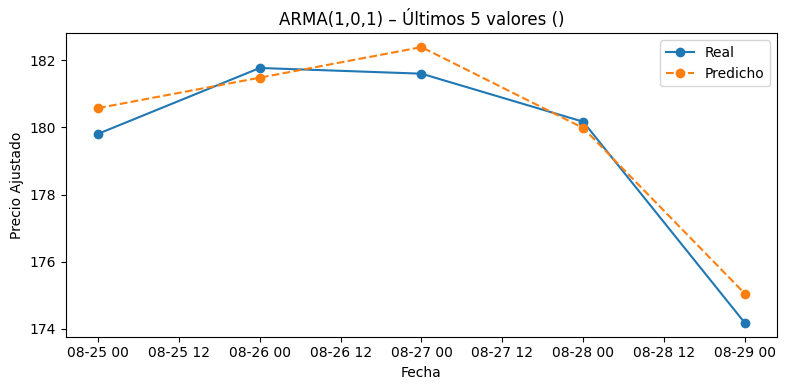

Últimos 5 valores reales vs predichos (ARMA – 1 mes bursátil):
            Precio_Real  Precio_Predicho
2025-08-25   179.809998       180.576081
2025-08-26   181.770004       181.481285
2025-08-27   181.600006       182.390665
2025-08-28   180.169998       179.983831
2025-08-29   174.179993       175.052234


In [264]:
tabla_arma_mes = pronostico_arma_mes_ultimos_5(
    serie_original=nvidia_series_mes['Adj Close'],
    serie_diff=nvidia_series_mes_diff1['Adj Close'],
    order=(1, 0, 1),
    pasos=5
)

print("Últimos 5 valores reales vs predichos (ARMA – 1 mes bursátil):")
print(tabla_arma_mes)


--- Modelo ajustado al conjunto de datos completo ---
Advertencia: No se pudo usar fechas futuras (Frecuencia no detectada). Se graficará usando 'Pasos'.


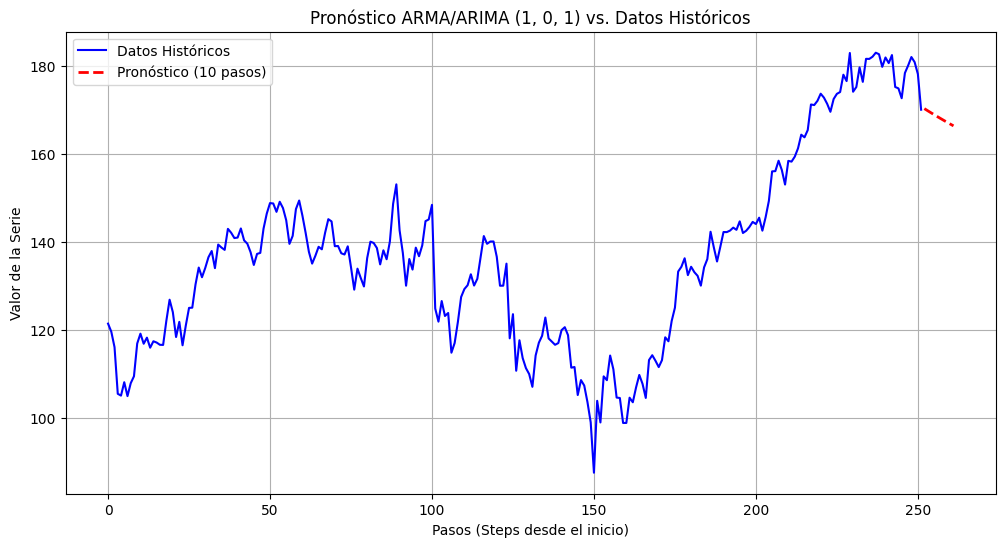


--- Resultados del Pronóstico (Primeros 5 valores) ---


,Pronostico
Paso Futuro,
252,170.249335
253,169.786746
254,169.331168
255,168.882495
256,168.440623
257,168.005448
258,167.576869
259,167.154786
260,166.739101


In [265]:
realizar_pronostico_arima_arma(ARIMA, nvidia_series_mes['NVDA'], order=(1, 0, 1), n_steps=10)

ARIMA

--- Modelo ajustado al conjunto de datos completo ---
Advertencia: No se pudo usar fechas futuras (Frecuencia no detectada). Se graficará usando 'Pasos'.


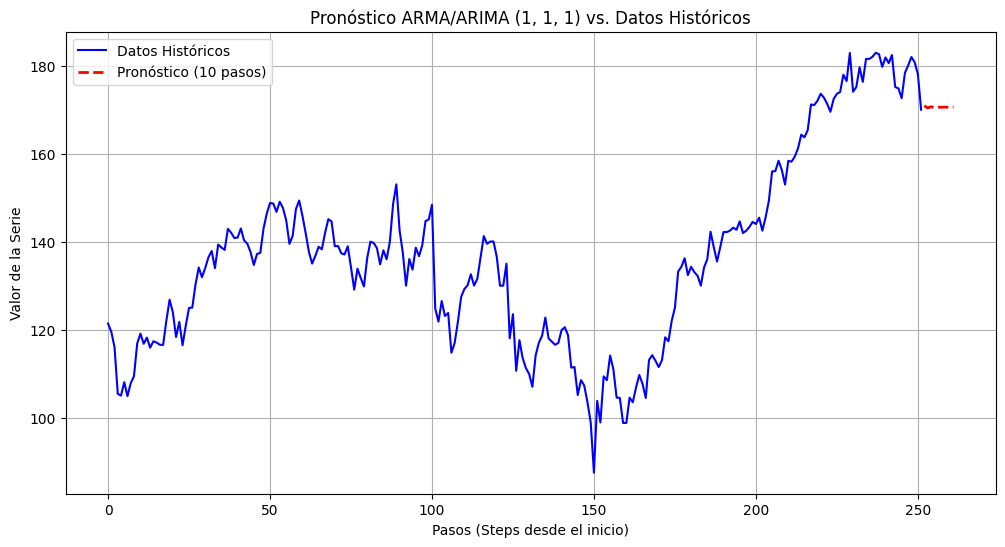


--- Resultados del Pronóstico (Primeros 5 valores) ---


,Pronostico
Paso Futuro,
252,170.900763
253,170.392507
254,170.679291
255,170.517473
256,170.608779
257,170.557259
258,170.586329
259,170.569926
260,170.579182


In [266]:
realizar_pronostico_arima_arma(ARIMA, nvidia_series_mes['NVDA'], order=(1, 1, 1), n_steps=10)

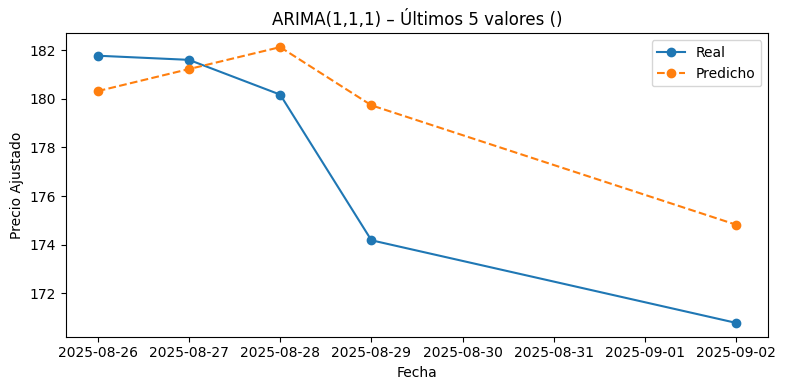

Últimos 5 valores reales vs predichos (ARIMA – 1 mes bursátil):
            Precio_Real  Precio_Predicho
2025-08-26   181.770004       180.313842
2025-08-27   181.600006       181.220527
2025-08-28   180.169998       182.123331
2025-08-29   174.179993       179.730720
2025-09-02   170.779999       174.817181


In [267]:
tabla_arima_mes = pronostico_arima_mes_ultimos_5(
    serie_original=nvidia_series_mes['Adj Close'],
    order=(1, 1, 1),
    pasos=5
)

print("Últimos 5 valores reales vs predichos (ARIMA – 1 mes bursátil):")
print(tabla_arima_mes)


Validación de errores

### Residuos del Modelo ARMA(1,1) (Anual)

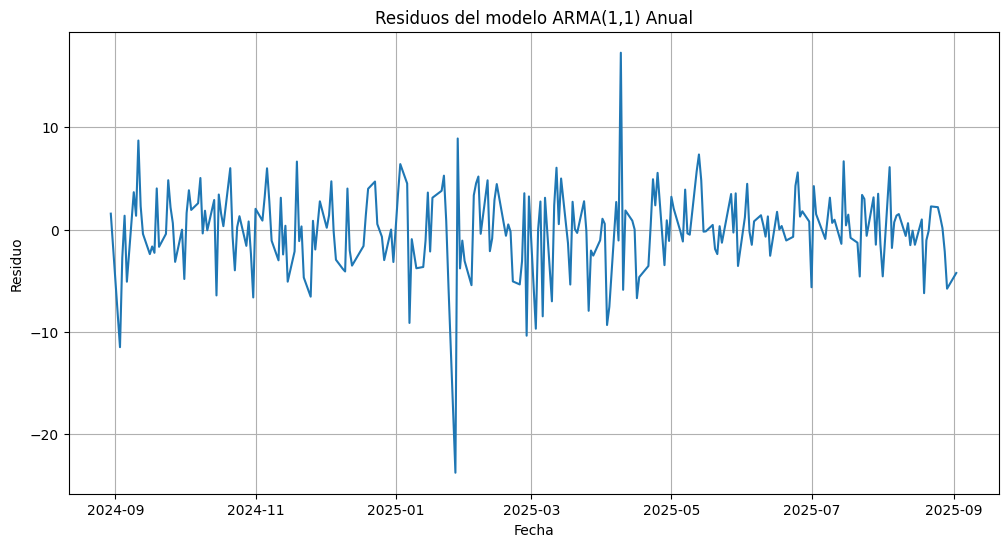

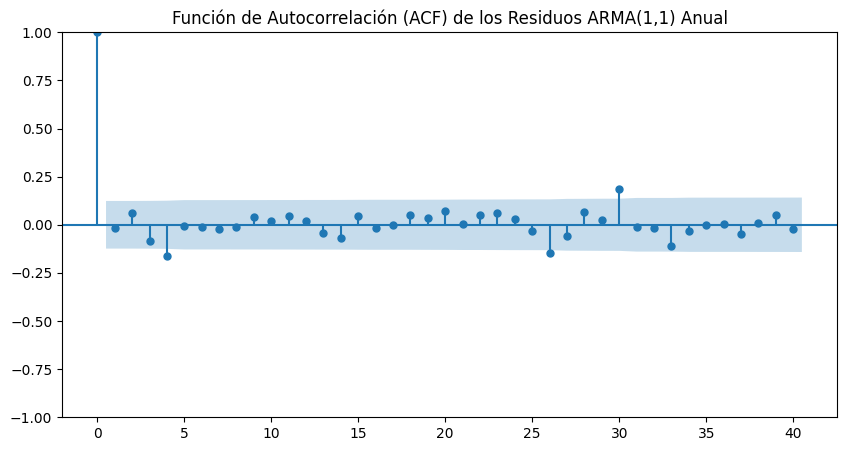

In [268]:
plot_model_residuals(arma_anual_normal_1, title_suffix='ARMA(1,1) Anual')

### Residuos del Modelo ARIMA(1,1,1) (Anual)

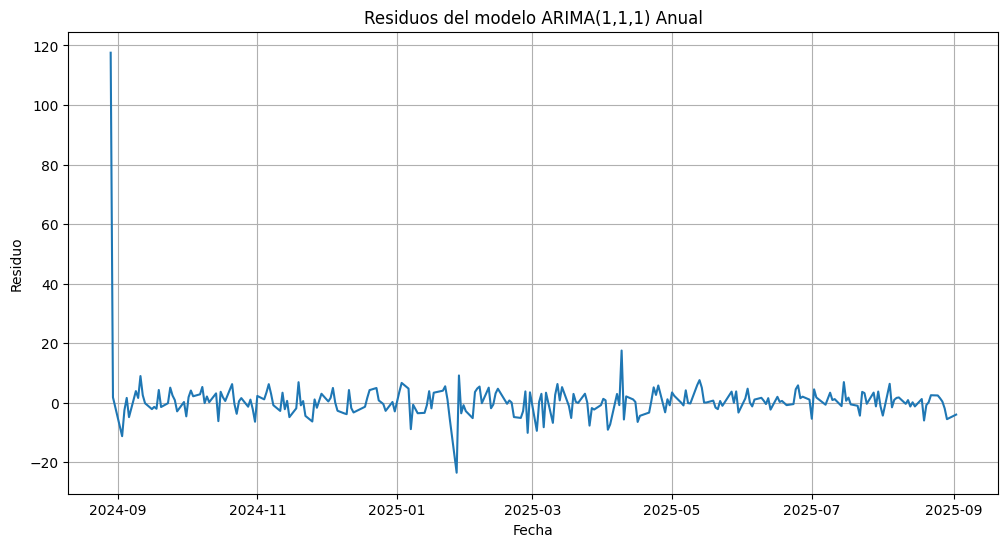

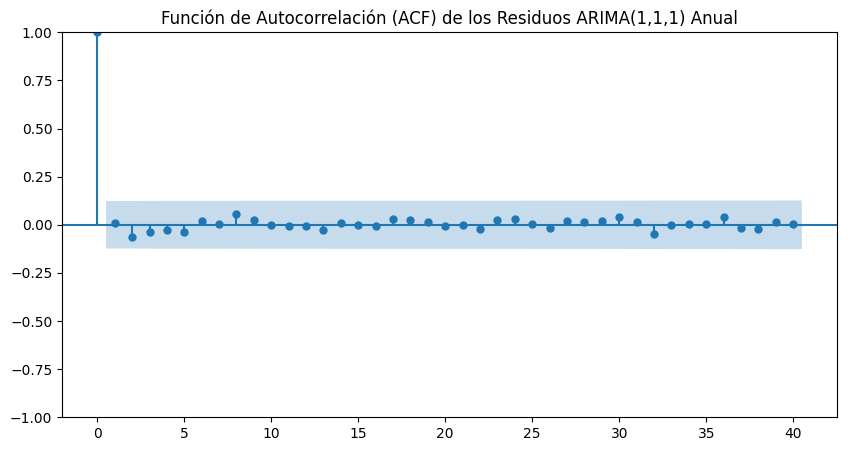

In [269]:
plot_model_residuals(arma_anual_dif_1, title_suffix='ARIMA(1,1,1) Anual')

### Residuos del Modelo ARMA(1,1) (Mensual)

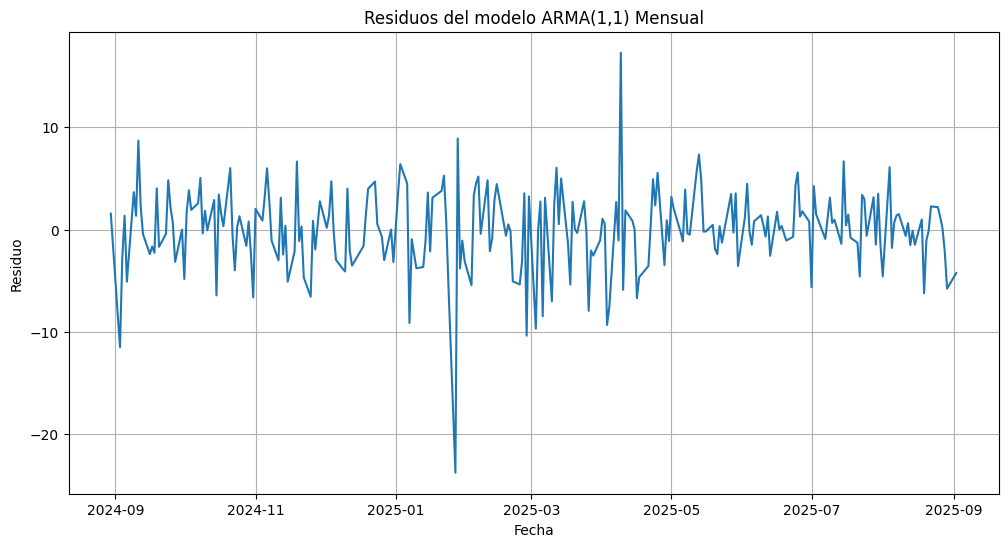

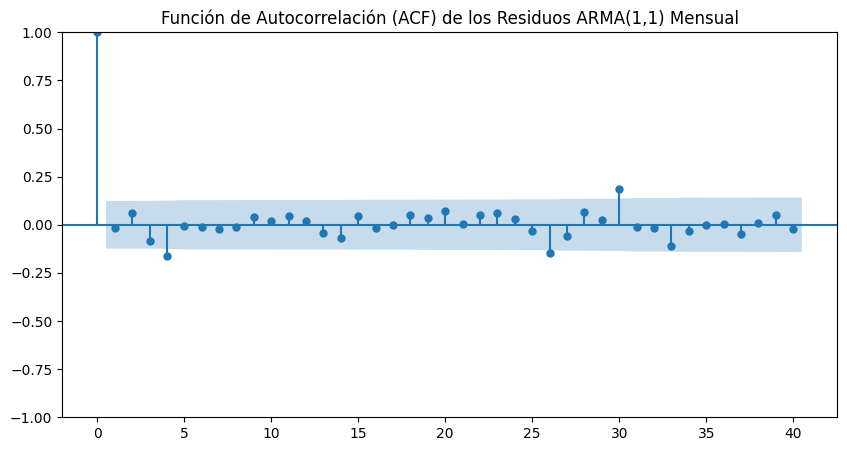

In [270]:
plot_model_residuals(arma_mensual_1, title_suffix='ARMA(1,1) Mensual')

### Residuos del Modelo ARIMA(1,1,1) (Mensual)

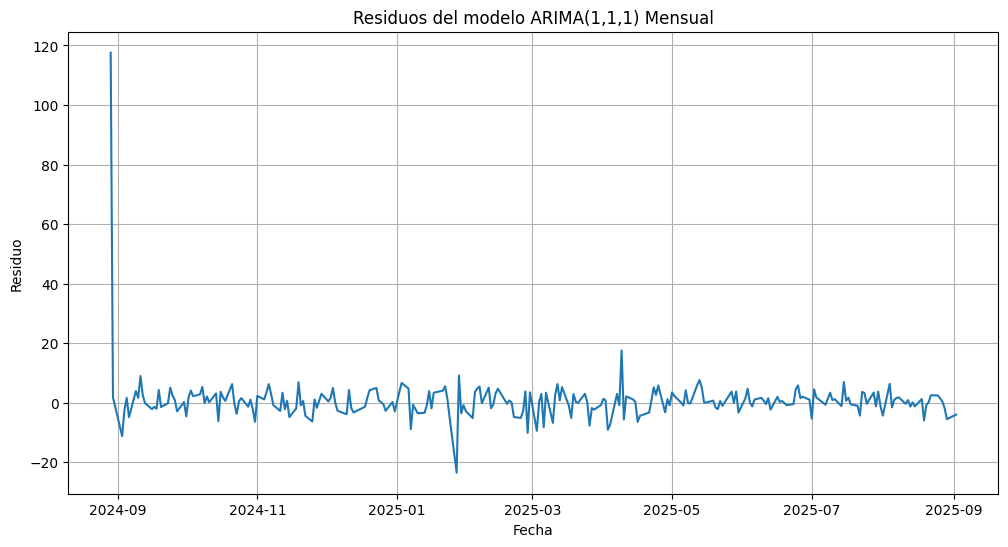

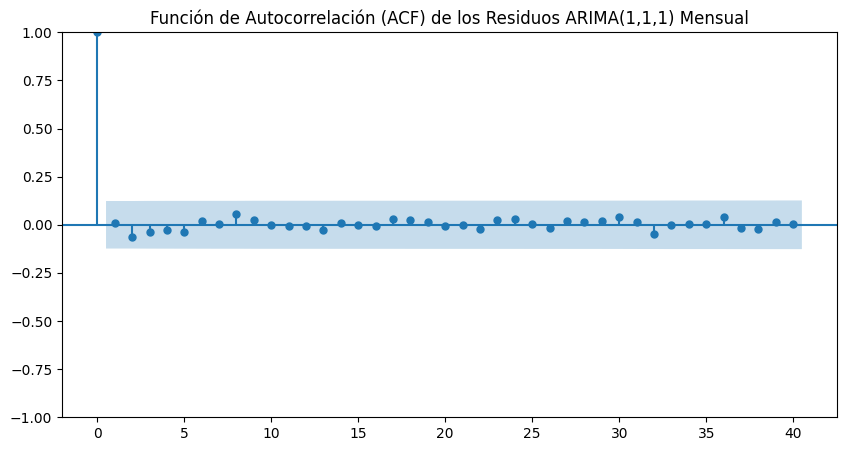

In [271]:
plot_model_residuals(arima_mensual_1, title_suffix='ARIMA(1,1,1) Mensual')

### Corroboración de Errores de Validación Cruzada

In [272]:
print('--- Resultados Promedio de Validación Cruzada (Anual) ---')
print(f'Modelo: ARMA(1, 0, 1)')
print(f'MAE Promedio:  {metricas_arma_año["MAE_Promedio"]:.4f}')
print(f'RMSE Promedio: {metricas_arma_año["RMSE_Promedio"]:.4f}')
print(f'MAPE Promedio: {metricas_arma_año["MAPE_Promedio"]:.4f}%')
print('----------------------------------------------------------')

print(f'Modelo: ARIMA(1, 1, 1)')
print(f'MAE Promedio:  {metricas_arima_año["MAE_Promedio"]:.4f}')
print(f'RMSE Promedio: {metricas_arima_año["RMSE_Promedio"]:.4f}')
print(f'MAPE Promedio: {metricas_arima_año["MAPE_Promedio"]:.4f}%')
print('----------------------------------------------------------')

print('\n--- Resultados Promedio de Validación Cruzada (Mensual) ---')
print(f'Modelo: ARMA(1, 0, 1)')
print(f'MAE Promedio:  {metricas_arma_mes["MAE_Promedio"]:.4f}')
print(f'RMSE Promedio: {metricas_arma_mes["RMSE_Promedio"]:.4f}')
print(f'MAPE Promedio: {metricas_arma_mes["MAPE_Promedio"]:.4f}%')
print('----------------------------------------------------------')

print(f'Modelo: ARIMA(1, 1, 1)')
print(f'MAE Promedio:  {metricas_arima_mes["MAE_Promedio"]:.4f}')
print(f'RMSE Promedio: {metricas_arima_mes["RMSE_Promedio"]:.4f}')
print(f'MAPE Promedio: {metricas_arima_mes["MAPE_Promedio"]:.4f}%')
print('----------------------------------------------------------')

--- Resultados Promedio de Validación Cruzada (Anual) ---
Modelo: ARMA(1, 0, 1)
MAE Promedio:  2.0013
RMSE Promedio: 2.6354
MAPE Promedio: 101.9760%
----------------------------------------------------------
Modelo: ARIMA(1, 1, 1)
MAE Promedio:  5.0477
RMSE Promedio: 6.3861
MAPE Promedio: 3.0897%
----------------------------------------------------------

--- Resultados Promedio de Validación Cruzada (Mensual) ---
Modelo: ARMA(1, 0, 1)
MAE Promedio:  2.0115
RMSE Promedio: 2.3909
MAPE Promedio: 108.6087%
----------------------------------------------------------
Modelo: ARIMA(1, 1, 1)
MAE Promedio:  2.8958
RMSE Promedio: 3.3722
MAPE Promedio: 1.6449%
----------------------------------------------------------


# GARCH

In [273]:
!pip install arch -q
!pip install pandas_datareader -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Conjunto de datos

In [274]:
file_path = '/content/nvidia.csv'

df = pd.read_csv(file_path)
df = df.rename(columns={'Unnamed: 1': 'Date', 'NVDA.3': 'Close'})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


Para modelar la volatilidad, seguimos una secuencia lógica de transformación de datos.

##Primero:
Se pasa a Retornos Logarítmicos. No se puede trabajar con los precios brutos porque NVIDIA ha tenido un crecimiento exponencial; un movimiento de 1 dólar en el año 2000 era un evento masivo, pero hoy es ruido. Al calcular el logaritmo de los retornos, estabilizamos la varianza y convertimos la serie en algo 'estacionario'. Esto significa que hacemos comparables los movimientos de hace 10 años con los de hoy, eliminando el efecto de la tendencia alcista.

##Segundo:
Se multiplica esos retornos por 100 (ajuste técnico): escalamos los datos. Como la varianza es el cuadrado del retorno, trabajar con decimales como 0.001 implicaría optimizar sobre números infinitesimales como 0.000001. Esto confunde a los algoritmos de optimización numérica(problema de underflow). Al multiplicar por 100, convertimos ese 0.001 en un 0.1 manejable. Esto asegura que el modelo GARCH converja matemáticamente sin errores.

In [275]:
df['Log_Return'] = np.log(df['Close']).diff() * 100
df = df.dropna()

print("Datos cargados. Total de días:", len(df))

Datos cargados. Total de días: 6454


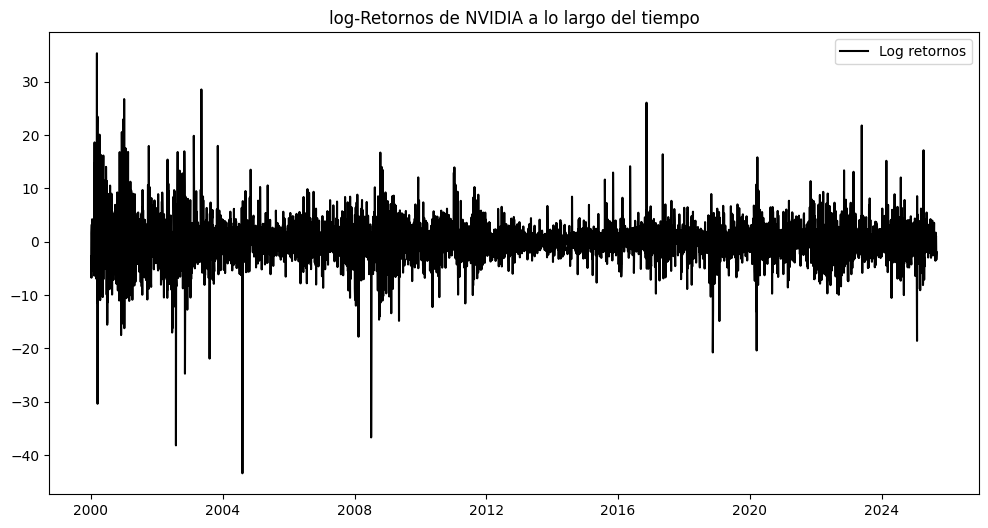

In [276]:
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Return'], label='Log retornos', color='black')
plt.title('log-Retornos de NVIDIA a lo largo del tiempo')
plt.legend()
plt.show()

# Modelo Ingenuo (Todos los datos de 2000-2025)





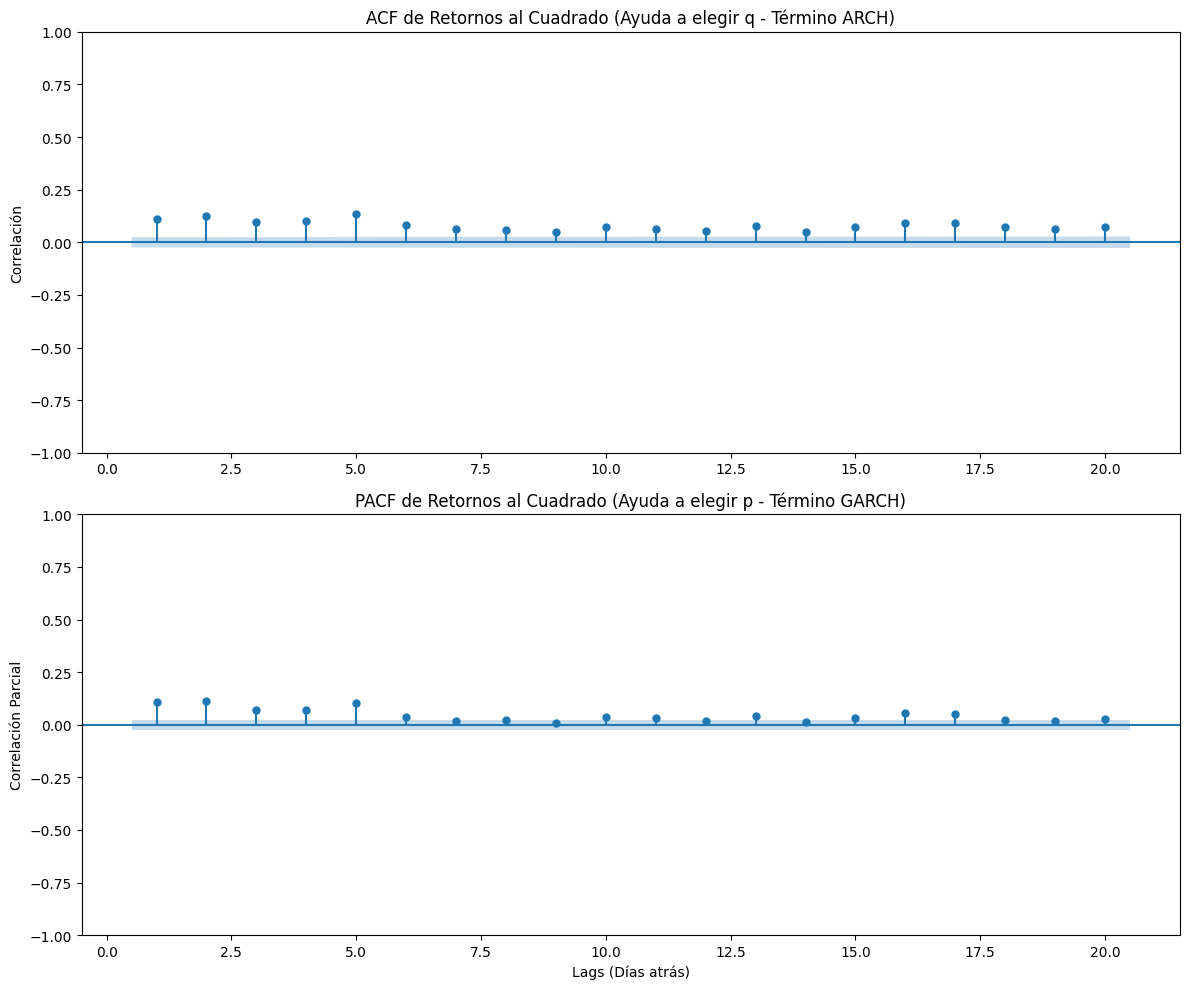

In [277]:
squared_returns = df['Log_Return'] ** 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(squared_returns, lags=20, ax=ax1, zero=False)
ax1.set_title('ACF de Retornos al Cuadrado (Ayuda a elegir q - Término ARCH)')
ax1.set_ylabel('Correlación')

plot_pacf(squared_returns, lags=20, ax=ax2, zero=False, method='ywm')
ax2.set_title('PACF de Retornos al Cuadrado (Ayuda a elegir p - Término GARCH)')
ax2.set_ylabel('Correlación Parcial')
ax2.set_xlabel('Lags (Días atrás)')

plt.tight_layout()
plt.show()

In [278]:
model_full = arch_model(df['Log_Return'], vol='Garch', p=1, q=1, dist='Normal')
res_full = model_full.fit(disp='off')

print(f"AIC del Modelo Completo: {res_full.aic:.2f}")
print("Problema: Este modelo asume que la NVIDIA de 2000 es igual a la de 2025.")


AIC del Modelo Completo: 33490.23
Problema: Este modelo asume que la NVIDIA de 2000 es igual a la de 2025.


# Diagnostico visual

Se genera una métrica dinámica que evalúa la estabilidad del activo a lo largo del tiempo. Calcula la volatilidad histórica proyectada a un año, basándose en el comportamiento observado durante los últimos 12 meses operativos.

- Ventana de Observación (rolling): En lugar de analizar la historia como un bloque estático, se utiliza una "ventana móvil" de 252 días (equivalente a un año bursátil). Esto permite evaluar cómo ha evolucionado el perfil de riesgo de la empresa día tras día.

- Medición de Fluctuaciones (std): Dentro de esa ventana anual, se calcula la desviación estándar de los retornos. En términos financieros, esto cuantifica la intensidad de las variaciones del precio: un valor bajo indica estabilidad, mientras que un valor alto señala dispersión e incertidumbre.

- La Varianza (riesgo al cuadrado) crece linealmente con el tiempo:$$\text{Varianza Anual} = \text{Varianza Diaria} \times 252$$Pero la Volatilidad es la raíz cuadrada de la Varianza. Por lo tanto, por reglas de álgebra:$$\text{Volatilidad Anual} = \sqrt{\text{Varianza Diaria} \times 252}$$$$\text{Volatilidad Anual} = \text{Volatilidad Diaria} \times \sqrt{252}$$

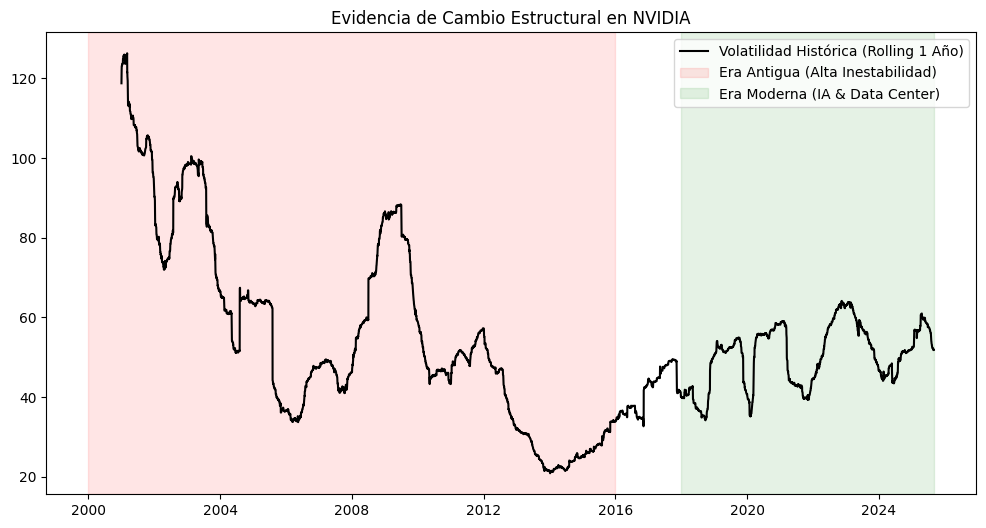

In [279]:
rolling_vol = df['Log_Return'].rolling(window=252).std() * np.sqrt(252)

plt.figure(figsize=(12, 6))
plt.plot(rolling_vol, label='Volatilidad Histórica (Rolling 1 Año)', color='black')
plt.axvspan(pd.to_datetime('2000-01-01'), pd.to_datetime('2016-01-01'), color='red', alpha=0.1, label='Era Antigua (Alta Inestabilidad)')
plt.axvspan(pd.to_datetime('2018-01-01'), df.index[-1], color='green', alpha=0.1, label='Era Moderna (IA & Data Center)')
plt.title('Evidencia de Cambio Estructural en NVIDIA')
plt.legend()
plt.show()



# Modelo sobre (2018-2025)




In [280]:
start_date = '2018-01-01'
df_modern = df.loc[start_date:].copy()
returns_modern = df_modern['Log_Return']

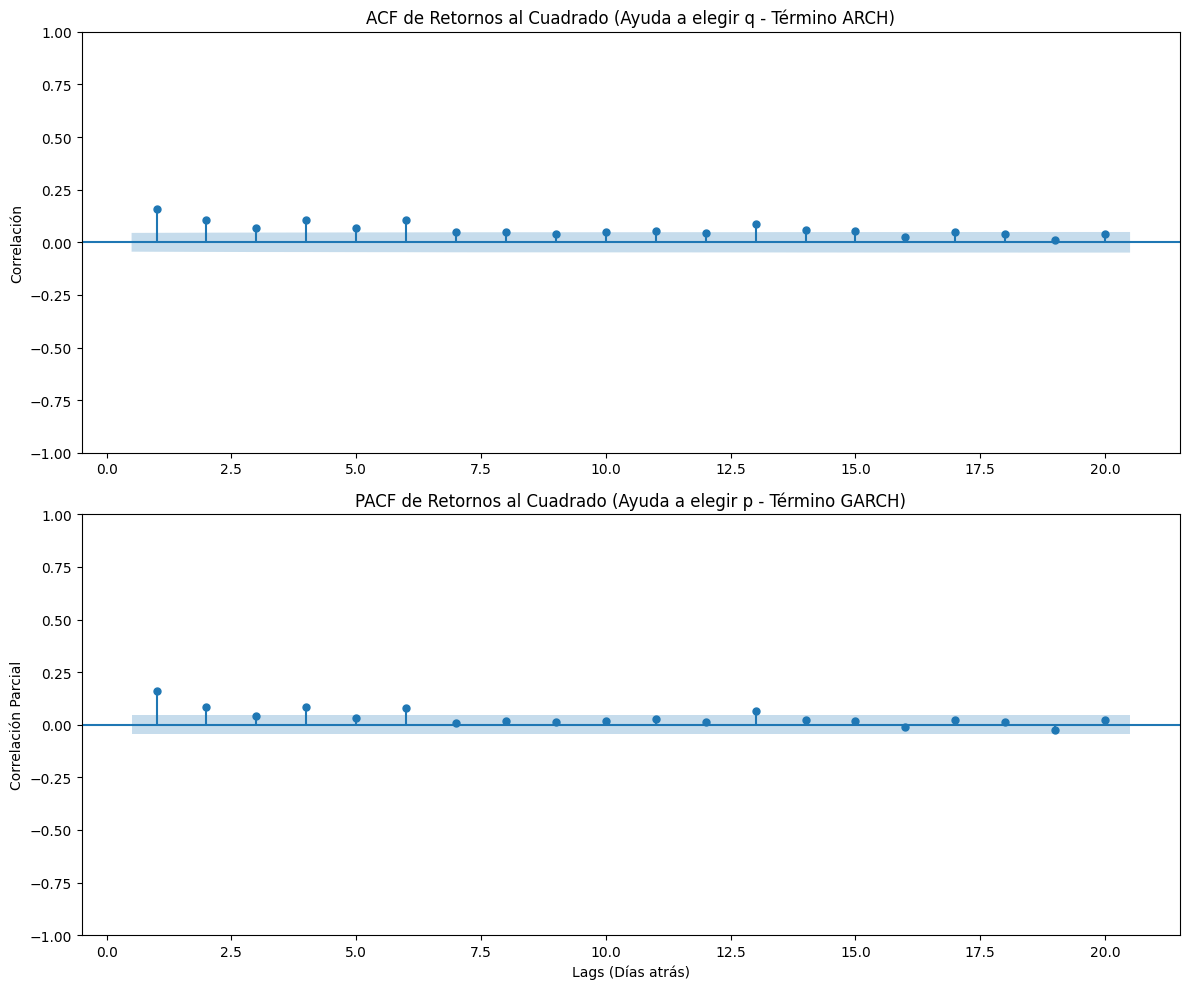

In [281]:
squared_returns = returns_modern ** 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(squared_returns, lags=20, ax=ax1, zero=False)
ax1.set_title('ACF de Retornos al Cuadrado (Ayuda a elegir q - Término ARCH)')
ax1.set_ylabel('Correlación')

plot_pacf(squared_returns, lags=20, ax=ax2, zero=False, method='ywm')
ax2.set_title('PACF de Retornos al Cuadrado (Ayuda a elegir p - Término GARCH)')
ax2.set_ylabel('Correlación Parcial')
ax2.set_xlabel('Lags (Días atrás)')

plt.tight_layout()
plt.show()

In [282]:
model_final = arch_model(returns_modern, vol='Garch', p=1, q=1)
res_final = model_final.fit(disp='off')

print(res_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4892.01
Distribution:                  Normal   AIC:                           9792.03
Method:            Maximum Likelihood   BIC:                           9814.28
                                        No. Observations:                 1927
Date:                Thu, Dec 18 2025   Df Residuals:                     1926
Time:                        14:50:11   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2674  6.559e-02      4.077  4.562e-05 [  0.139,  0.39

# Validación y forecasting del modelo final





Iniciando Walk-Forward Validation para los últimos 252 días...
Progreso: Día 0/252
Progreso: Día 50/252
Progreso: Día 100/252
Progreso: Día 150/252
Progreso: Día 200/252
Progreso: Día 250/252

--- RESULTADOS DE VALIDACIÓN ---
RMSE (Error Cuadrático): 2.4689
MAE  (Error Absoluto):   1.8456  <-- En promedio fallamos por esta cantidad
MAPE (Error Porcentual): 595.99%


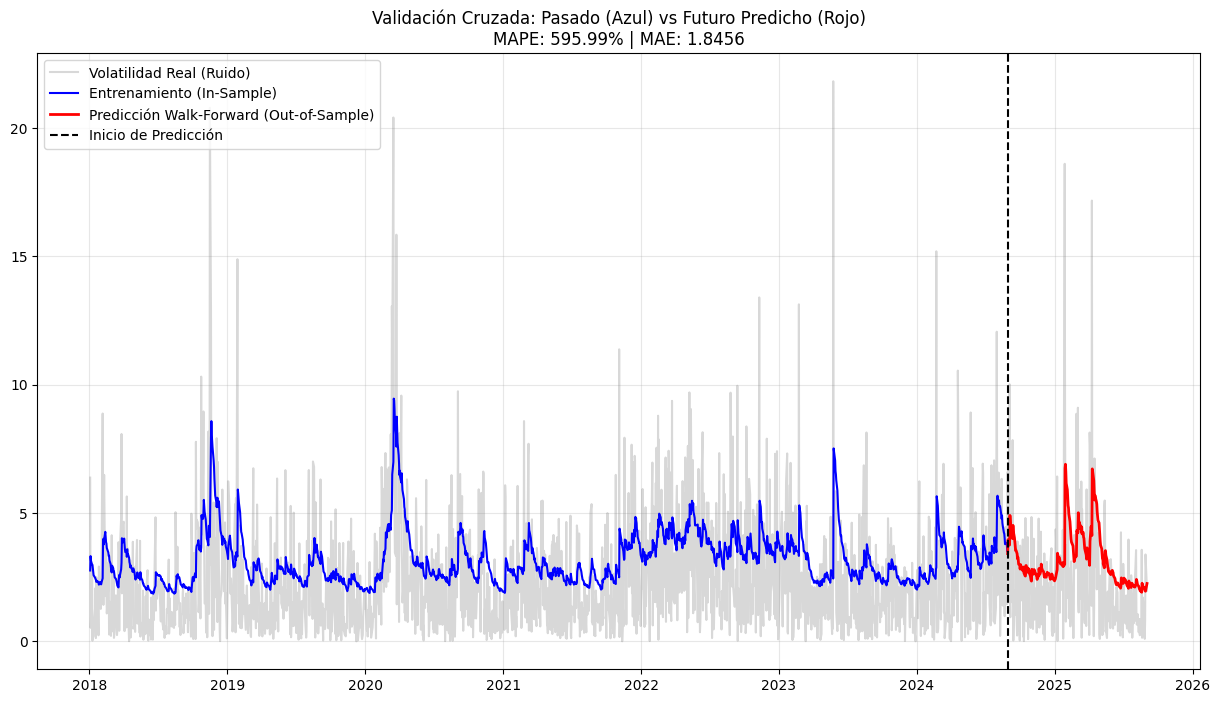

In [284]:
df = pd.read_csv("/content/nvidia.csv")
df = df.rename(columns={'Unnamed: 1': 'Date', 'NVDA.3': 'Close'})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df_modern = df.loc['2018-01-01':].copy()
returns_modern = np.log(df_modern['Close']).diff().dropna() * 100


test_days = 252 # Último año
total_len = len(returns_modern)
train_size = total_len - test_days

forecasts = []
actuals = []

print(f"Iniciando Walk-Forward Validation para los últimos {test_days} días...")

for i in range(test_days):
    train_window = returns_modern.iloc[:train_size + i]


    model = arch_model(train_window, vol='Garch', p=1, q=1, dist='t')
    res = model.fit(disp='off')

    pred = res.forecast(horizon=1)
    pred_vol = np.sqrt(pred.variance.values[-1, :])[0]
    forecasts.append(pred_vol)

    actual_val = abs(returns_modern.iloc[train_size + i])
    actuals.append(actual_val)

    if i % 50 == 0:
        print(f"Progreso: Día {i}/{test_days}")

actuals = np.array(actuals)
forecasts = np.array(forecasts)

mse = mean_squared_error(actuals, forecasts)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, forecasts)
mape = np.mean(np.abs((actuals - forecasts) / (actuals + 1e-6))) * 100

print(f"\n--- RESULTADOS DE VALIDACIÓN ---")
print(f"RMSE (Error Cuadrático): {rmse:.4f}")
print(f"MAE  (Error Absoluto):   {mae:.4f}  <-- En promedio fallamos por esta cantidad")
print(f"MAPE (Error Porcentual): {mape:.2f}%")


train_initial = returns_modern.iloc[:train_size]
model_init = arch_model(train_initial, vol='Garch', p=1, q=1, dist='t')
res_init = model_init.fit(disp='off')
vol_past = res_init.conditional_volatility

dates_past = returns_modern.index[:train_size]
dates_test = returns_modern.index[train_size:]

plt.figure(figsize=(15, 8))
plt.plot(returns_modern.index, returns_modern.abs(), color='gray', alpha=0.3, label='Volatilidad Real (Ruido)')
plt.plot(dates_past, vol_past, color='blue', linewidth=1.5, label='Entrenamiento (In-Sample)')
plt.plot(dates_test, forecasts, color='red', linewidth=2, label='Predicción Walk-Forward (Out-of-Sample)')

# Decoración
plt.axvline(dates_test[0], color='black', linestyle='--', label='Inicio de Predicción')
plt.title(f'Validación Cruzada: Pasado (Azul) vs Futuro Predicho (Rojo)\nMAPE: {mape:.2f}% | MAE: {mae:.4f}')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

#MAPE alto

$$MAPE = \frac{1}{n} \sum \left| \frac{\text{Real} - \text{Predicho}}{\text{Real}} \right| \times 100$$


 El problema reside en el denominador ($\text{Real}$). En series financieras, los retornos diarios frecuentemente son valores muy cercanos a cero (ej. $0.05\%$). Al dividir cualquier error de predicción, por pequeño que sea, entre un número casi nulo, el resultado matemático tiende a infinito (el "Problema del Denominador Pequeño").